<a href="https://colab.research.google.com/github/christopher-reed/CA-High-Value-Crops/blob/master/Crop_Weather_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Formatting Weather Data

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
df_weather = pd.read_csv('county_level_weather.csv')
df_weather.head()

Unnamed: 0  County  Var  ...     October    November    December
0           0  Sierra  ppt  ...   33.582626   41.988926  120.442238
1           1  Sierra  ppt  ...  174.779312  504.357941  377.453613
2           2  Sierra  ppt  ...  202.075043  250.340317  253.627685
3           3  Sierra  ppt  ...   91.135620  504.704224  429.239380
4           4  Sierra  ppt  ...  103.931931  325.303803   62.782768

[5 rows x 16 columns]

In [0]:
df_weather['Var'].unique()

array(['ppt', 'tmax', 'tmin', 'tmean', 'vpdmax', 'vpdmin'], dtype=object)

**Currently the data is quite hard to query because you have to query the Var column and then select each month. It would be a little easier if we had a column for ppt in January or VPDmax in March.**

In [0]:
#Plan: Make a bunch of series and then concat them all into a df

#List the months and variables
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
variables = df_weather['Var'].unique()

#List to store all the dfs
df_list = []

#Iterate through months
for month in months:
  
  #Filter to month
  df_month = df_weather[['County', 'Year','Var', month]]
  
  #Iterate through vars
  for var in variables:
    
    #Name column
    desired_name = month+ '_' + var
   
    #Filter to variables
    df_month_var = df_month.loc[df_month['Var'] == var].rename(columns = {month:month+ '_' + var}).drop(['Var'], axis = 1)
    
    #Append to list
    df_list.append(df_month_var)


**We have a list of all of our dfs. We now want to merge them on county and year. We can use [reduce()](https://book.pythontips.com/en/latest/map_filter.html) from functools to do a "rolling" computation.**

In [0]:
from functools import reduce
df_weather_merged = reduce(lambda  left,right: pd.merge(left,right,on=['County', 'Year'],
                                            how='outer'), df_list)

**Check out the result. This will be much easier to query!**

In [0]:
df_weather_merged.head()

County  Year  January_ppt  ...  December_tmean  December_vpdmax  December_vpdmin
0  Sierra  1980   415.709686  ...        3.386014         7.433448         1.787973
1  Sierra  1981   236.459885  ...        2.496554         4.770134         0.884527
2  Sierra  1982   229.290253  ...       -0.805878         4.395406         0.615068
3  Sierra  1983   232.798508  ...        0.471892         3.131824         0.621014
4  Sierra  1984    17.905682  ...       -1.388446         4.449865         0.787703

[5 rows x 74 columns]

# Yield Data

**Crop Selection**

**Load in yield data. Inspect it.**

In [0]:
df_yield = pd.read_csv('California Crop Yields.csv')

#Filter out the non-county rows
df_counties = df_yield[df_yield['County Code'] < 900].drop('Unnamed: 0', axis = 1)

#Inspect
df_counties.head()

Year  Commodity Code    Crop Name  ...  Price per Unit   Unit  Total Value
0  1980          261999  ALMONDS ALL  ...          3000.0  TONS    39651000.0
1  1980          261999  ALMONDS ALL  ...          3600.0  TONS       43200.0
2  1980          261999  ALMONDS ALL  ...          2800.0  TONS     5880000.0
3  1980          261999  ALMONDS ALL  ...          1440.0  TONS      818000.0
4  1980          261999  ALMONDS ALL  ...          3000.0  TONS    42600000.0

[5 rows x 11 columns]

In [0]:
df_counties['Crop Name'].unique()

array(['ALMONDS ALL', 'GRAPES WINE', 'WALNUTS ENGLISH',
       'TOMATOES PROCESSING', 'PISTACHIOS', 'GRAPES TABLE',
       'LETTUCE HEAD', 'BERRIES STRAWBERRIES PROCESSING'], dtype=object)

# Join Yield and Weather

**Next step is to introduce the yield data which was obtained in a seperate notebook. We want to join this to the weather data on county and year.**

In [0]:
df_yield = pd.read_csv('California Crop Yields.csv')

#Filter out the non-county rows
df_counties = df_yield[df_yield['County Code'] < 900].drop('Unnamed: 0', axis = 1)

#Inspect
df_counties.head()

Year  Commodity Code    Crop Name  ...  Price per Unit   Unit  Total Value
0  1980          261999  ALMONDS ALL  ...          3000.0  TONS    39651000.0
1  1980          261999  ALMONDS ALL  ...          3600.0  TONS       43200.0
2  1980          261999  ALMONDS ALL  ...          2800.0  TONS     5880000.0
3  1980          261999  ALMONDS ALL  ...          1440.0  TONS      818000.0
4  1980          261999  ALMONDS ALL  ...          3000.0  TONS    42600000.0

[5 rows x 11 columns]

**Perform join.**

In [0]:
#Join on county and year fields. Use inner join b/c we want data that has BOTH
#yield and weather data
df_weather_yield = df_weather_merged.merge(df_counties, how = 'inner', on = ['County', 'Year'])

#Inspect
df_weather_yield.head()

County  Year  January_ppt  ...  Price per Unit   Unit  Total Value
0  Sacramento  1980   144.467880  ...           210.0  TONS     5628000.0
1  Sacramento  1980   144.467880  ...           951.0  TONS      351000.0
2  Sacramento  1980   144.467880  ...            48.0  TONS    11805000.0
3  Sacramento  1981   132.503296  ...           224.0  TONS     5242000.0
4  Sacramento  1981   132.503296  ...          1000.0  TONS      410000.0

[5 rows x 83 columns]

# Feature Engineering

**It is possible that cumulative precipitation is more useful than the precipitation in one month. Sum up three months of precipitation data.**

**Jan + Feb + Mar = JPM**
**Feb + Mar + Apr = FMA Precip**

**So on and so forth...**

In [0]:
#Function to add a "window" of precipitation
def precip_window(month_window):

  #Create name
  var = month_window[0][0] + month_window[1][0] + month_window[2][0]
  var_ppt = var + '_ppt'

  #Make new column
  df_weather_yield[var_ppt] = df_weather_yield[month_window[0]] + df_weather_yield[month_window[1]] + df_weather_yield[month_window[2]]


In [0]:
#List of all possible windows
windows = [['January_ppt', 'February_ppt', 'March_ppt'],
           ['February_ppt', 'March_ppt', 'April_ppt'],
           ['March_ppt', 'April_ppt', 'May_ppt'],
           ['April_ppt', 'May_ppt', 'June_ppt'],
           ['May_ppt', 'June_ppt', 'July_ppt'],
           ['June_ppt', 'July_ppt', 'August_ppt'],
           ['July_ppt', 'August_ppt', 'September_ppt'],
           ['August_ppt', 'September_ppt', 'October_ppt'],
           ['September_ppt', 'October_ppt', 'November_ppt'],
           ['October_ppt', 'November_ppt', 'December_ppt'],
           ['November_ppt', 'December_ppt', 'January_ppt'],
            ['December_ppt', 'January_ppt', 'February_ppt']]

#Use function
for window in windows:
  precip_window(window)

**In our model it will be important to consider the squares of some of our variables. We can add those columns now.**

In [0]:
#We don't want to square these!
unaltered_vars = ['Year','County','Commodity Code', 'Crop Name', 'County Code', 'Harvested Acres',
                 'Yield per Acre', 'Production', 'Price per Unit', 'Total Value',
                 'Unit']

for column in list(df_weather_yield.columns):
  
  if column in unaltered_vars:
    continue
    
  else:
    name = column
    new_name = column + '_2'
    
    df_weather_yield[new_name] = df_weather_yield.apply(lambda x: x[name]**2, axis = 1)

**Inspect output. Should be over 170 columns. The variables we didn't square are still there, they are just not displayed in this output.**

In [0]:
df_weather_yield.head()

County  Year  January_ppt  ...     OND_ppt_2      NDJ_ppt_2      DJF_ppt_2
0  Sacramento  1980   144.467880  ...   3367.605970   39882.113163  136176.602542
1  Sacramento  1980   144.467880  ...   3367.605970   39882.113163  136176.602542
2  Sacramento  1980   144.467880  ...   3367.605970   39882.113163  136176.602542
3  Sacramento  1981   132.503296  ...  94141.969692  146961.842448   63320.316365
4  Sacramento  1981   132.503296  ...  94141.969692  146961.842448   63320.316365

[5 rows x 179 columns]

**In this study we are going to account for fixed effects within each county. We can do this by creating dummy variables for each county. Use [pd.get_dummies()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) to do this.**

In [0]:
#Make a bunch of columns. One for each county.
dummy_counties = pd.get_dummies(df_weather_yield['County'])

#Concat them to original df and rename to preserve original
df_fixed = pd.concat([df_weather_yield, dummy_counties], axis = 1)
df_fixed.shape

(4852, 228)

**At this point we are going to do seperate operations for the df that considers fixed effects (df_fixed) and the df that does not consider fixed effect (df_weather_yield). Doing this because it will make the exploratory analysis much cleaner.**

**Fixed Effects: Now we are going to center all of our variables on their respective mean over the domain. Achieved by subtracting each column by its mean. We will groupby the crop name.**

In [0]:
#Groupby
df_means_fixed = df_fixed.groupby('Crop Name').mean()
df_means_fixed = df_means_fixed.reset_index()

#Inspect
df_means_fixed.head()

Crop Name         Year  ...      Yolo      Yuba
0                      ALMONDS ALL  1997.301611  ...  0.055637  0.055637
1  BERRIES STRAWBERRIES PROCESSING  2000.093525  ...  0.000000  0.000000
2                     GRAPES TABLE  1997.850000  ...  0.006667  0.003333
3                      GRAPES WINE  1999.517872  ...  0.031588  0.011638
4                     LETTUCE HEAD  1999.721622  ...  0.000000  0.000000

[5 rows x 226 columns]

**Fixed Effects: Next step is to center our data on the respective mean.**

In [0]:
#Make a deep copy of df_weather_yield to preserve the original
df_centered_fixed = df_fixed.copy(deep = True)

#Specify variables
variables = list(df_fixed.columns)
crops = df_fixed['Crop Name'].unique()

#List of variables we don't want to subtract mean from
unaltered_vars = ['County','Commodity Code', 'Crop Name', 'County Code', 'Harvested Acres',
                 'Yield per Acre', 'Production', 'Price per Unit', 'Total Value',
                 'Unit']


for crop in crops:

  for var in variables:
    
    if var in unaltered_vars:
      continue
      
    else:
      #Extract mean of variable for specific crop
      var_mean = df_means_fixed.loc[df_means_fixed['Crop Name'] == crop,var].values[0]
      
      #Subtract the mean from the original data
      result = df_fixed[df_fixed['Crop Name'] == crop][var] - var_mean
      
      #Save result in df_centered
      df_centered_fixed.loc[df_centered_fixed['Crop Name'] == crop, var] = result

**Fixed Effects: Inspect the data**

In [0]:
df_centered_fixed.head()

County       Year  January_ppt  ...   Ventura      Yolo      Yuba
0  Sacramento -19.517872    20.740280  ...  0.000000 -0.031588 -0.011638
1  Sacramento -17.262755    17.726157  ... -0.007653 -0.032313 -0.032313
2  Sacramento -16.895935    56.351026  ... -0.014634 -0.061789  0.000000
3  Sacramento -18.517872     8.775696  ...  0.000000 -0.031588 -0.011638
4  Sacramento -16.262755     5.761573  ... -0.007653 -0.032313 -0.032313

[5 rows x 228 columns]

**Now perform the above operations, but now for the df not considering fixed effects (df_weather_yield).**

In [0]:
#Groupby
df_means = df_weather_yield.groupby('Crop Name').mean()
df_means = df_means.reset_index()

#Inspect
df_means_fixed.head()

Crop Name         Year  ...      Yolo      Yuba
0                      ALMONDS ALL  1997.301611  ...  0.055637  0.055637
1  BERRIES STRAWBERRIES PROCESSING  2000.093525  ...  0.000000  0.000000
2                     GRAPES TABLE  1997.850000  ...  0.006667  0.003333
3                      GRAPES WINE  1999.517872  ...  0.031588  0.011638
4                     LETTUCE HEAD  1999.721622  ...  0.000000  0.000000

[5 rows x 226 columns]

In [0]:
#Make a deep copy of df_weather_yield to preserve the original
df_centered = df_weather_yield.copy(deep = True)

#Specify variables
variables = list(df_weather_yield.columns)
crops = df_weather_yield['Crop Name'].unique()

#List of variables we don't want to subtract mean from
unaltered_vars = ['County','Commodity Code', 'Crop Name', 'County Code', 'Harvested Acres',
                 'Yield per Acre', 'Production', 'Price per Unit', 'Total Value',
                 'Unit']

for crop in crops:

  for var in variables:
    
    if var in unaltered_vars:
      continue
      
    else:
      #Extract mean of variable for specific crop
      var_mean = df_means.loc[df_means['Crop Name'] == crop,var].values[0]
      
      #Subtract the mean from the original data
      result = df_weather_yield[df_weather_yield['Crop Name'] == crop][var] - var_mean
      
      #Save result in df_centered
      df_centered.loc[df_centered['Crop Name'] == crop, var] = result

**No Fixed Effects: Now we can check out our centered data.**

In [0]:
df_centered.head()

County       Year  ...      NDJ_ppt_2      DJF_ppt_2
0  Sacramento -19.517872  ... -117389.541894  -60175.016319
1  Sacramento -17.262755  ... -116305.661164  -55616.154010
2  Sacramento -16.895935  ...  -20509.330697   53304.533205
3  Sacramento -18.517872  ...  -10309.812608 -133031.302496
4  Sacramento -16.262755  ...   -9225.931879 -128472.440187

[5 rows x 179 columns]

# Exploratory Analysis

There are a lot of predictor varaibles in our data, so the traditional EDA of making scatter plots and correlation heat maps for every combination of predictor and target is not feasible or informative. The following EDA looks at the 3 strongest positive and 3 strongest negative correlations between the predictors and target for each crop.

**Create function that plots a scatter plot for each of the six correlations.**

In [0]:
#Function to plot 6 scatter plots. One for each correlation. Hue is county name.
def plot_matrix(vars, crop, corr_values):

  df_crop = df_centered[df_centered['Crop Name'] == crop]

  fig, axes = plt.subplots(2, 3, figsize = (15,15), sharey = True)

  sns.scatterplot(x = vars[0], y = 'Yield per Acre', hue = 'County', legend = False, data = df_crop, ax =axes[0,0])
  axes[0,0].set_title('r = ' + str(round(corr_values[0],3)))

  sns.scatterplot(x = vars[1], y = 'Yield per Acre', hue = 'County', legend = False, data = df_crop, ax =axes[0,1])
  axes[0,1].set_title('r = ' + str(round(corr_values[1],3)))

  sns.scatterplot(x = vars[2], y = 'Yield per Acre', hue = 'County', legend = False, data = df_crop, ax =axes[0,2])
  axes[0,2].set_title('r = ' + str(round(corr_values[2],3)))

  sns.scatterplot(x = vars[3], y = 'Yield per Acre', hue = 'County', legend = False, data = df_crop, ax =axes[1,0])
  axes[1,0].set_title('r = ' + str(round(corr_values[3],3)))

  sns.scatterplot(x = vars[4], y = 'Yield per Acre', hue = 'County', legend = False, data = df_crop, ax =axes[1,1])
  axes[1,1].set_title('r = ' + str(round(corr_values[4],3)))

  sns.scatterplot(x = vars[5], y = 'Yield per Acre', hue = 'County', data = df_crop, ax =axes[1,2])
  axes[1,2].set_title('r = ' + str(round(corr_values[5],3)))

  axes[1,2].legend(title = 'County', loc = 'center right', bbox_to_anchor = (2.0,1.2), ncol = 2)

  plt.suptitle(crop, fontsize = 20, x = 0.51, y = 0.93)

**Identify the 3 strongest positive and 3 strongest negative correlations. Then plot the scatter plots.**

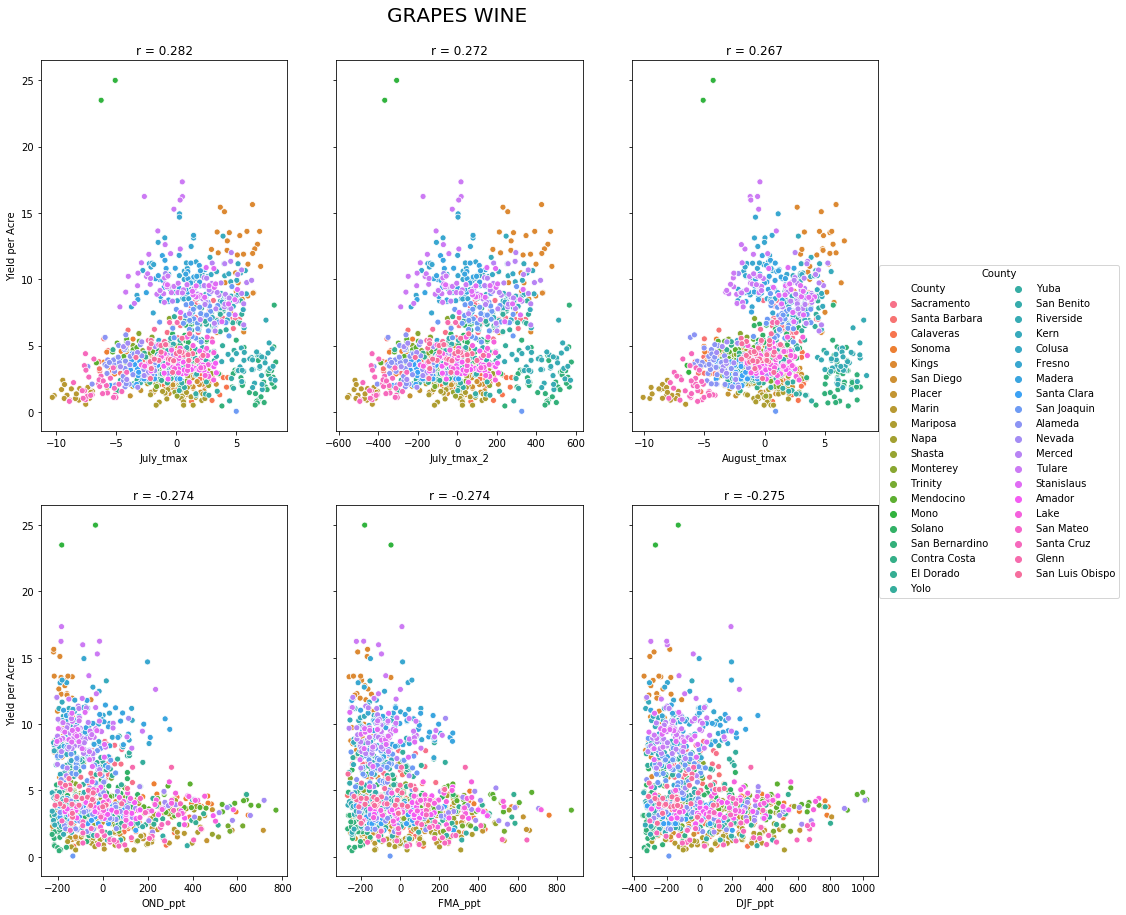

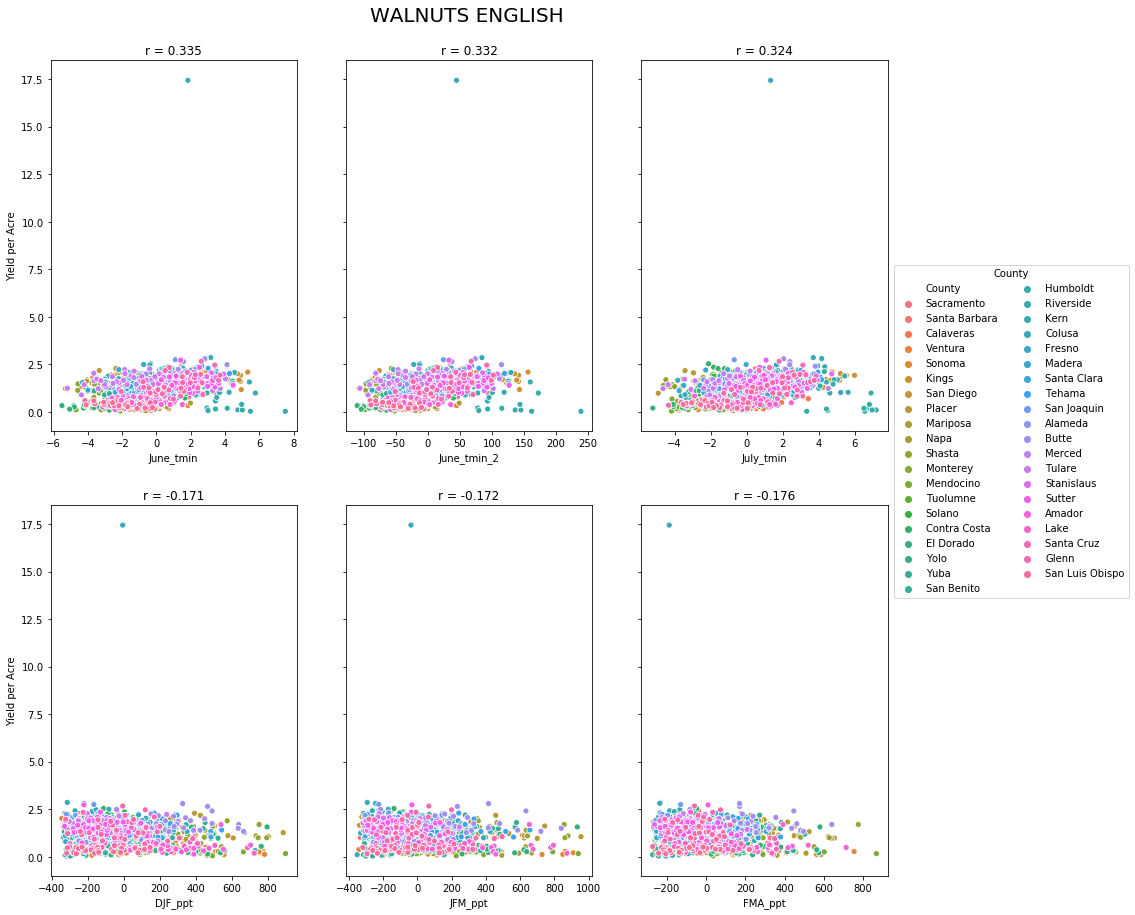

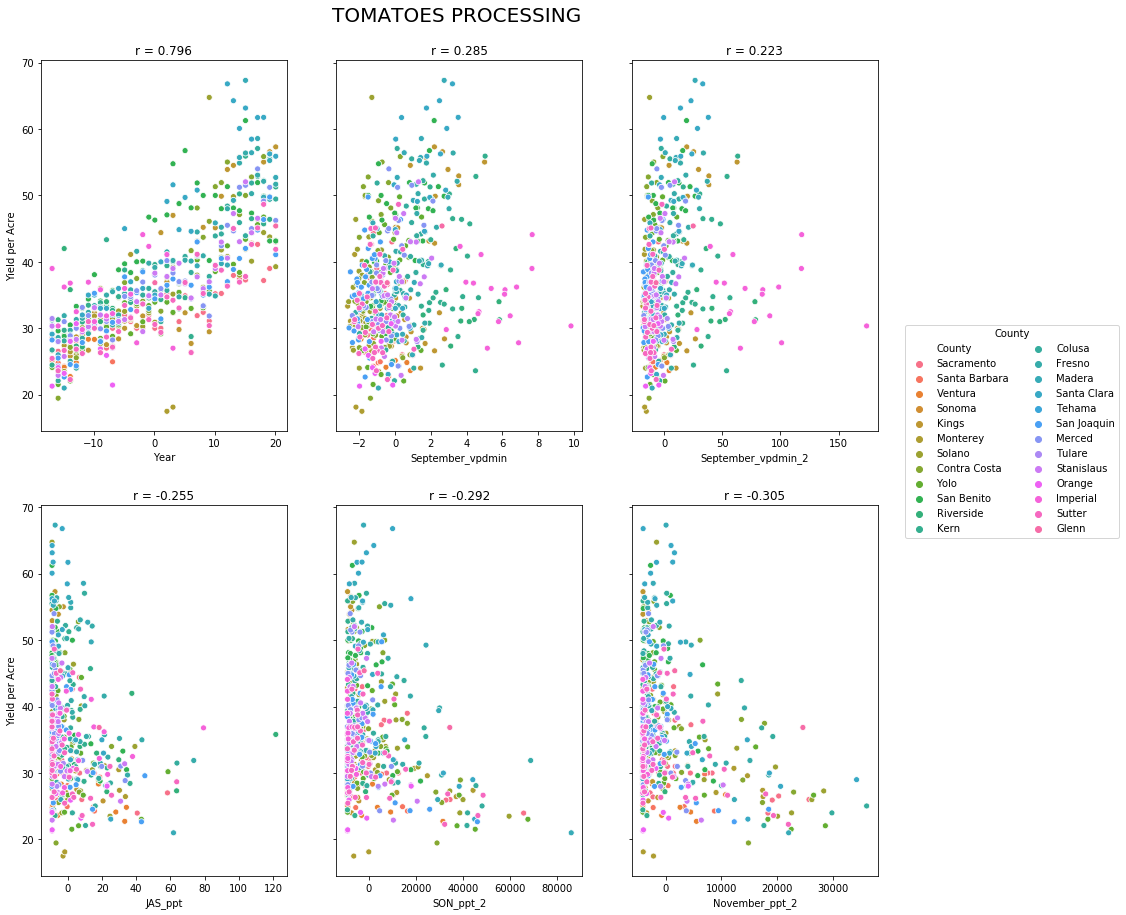

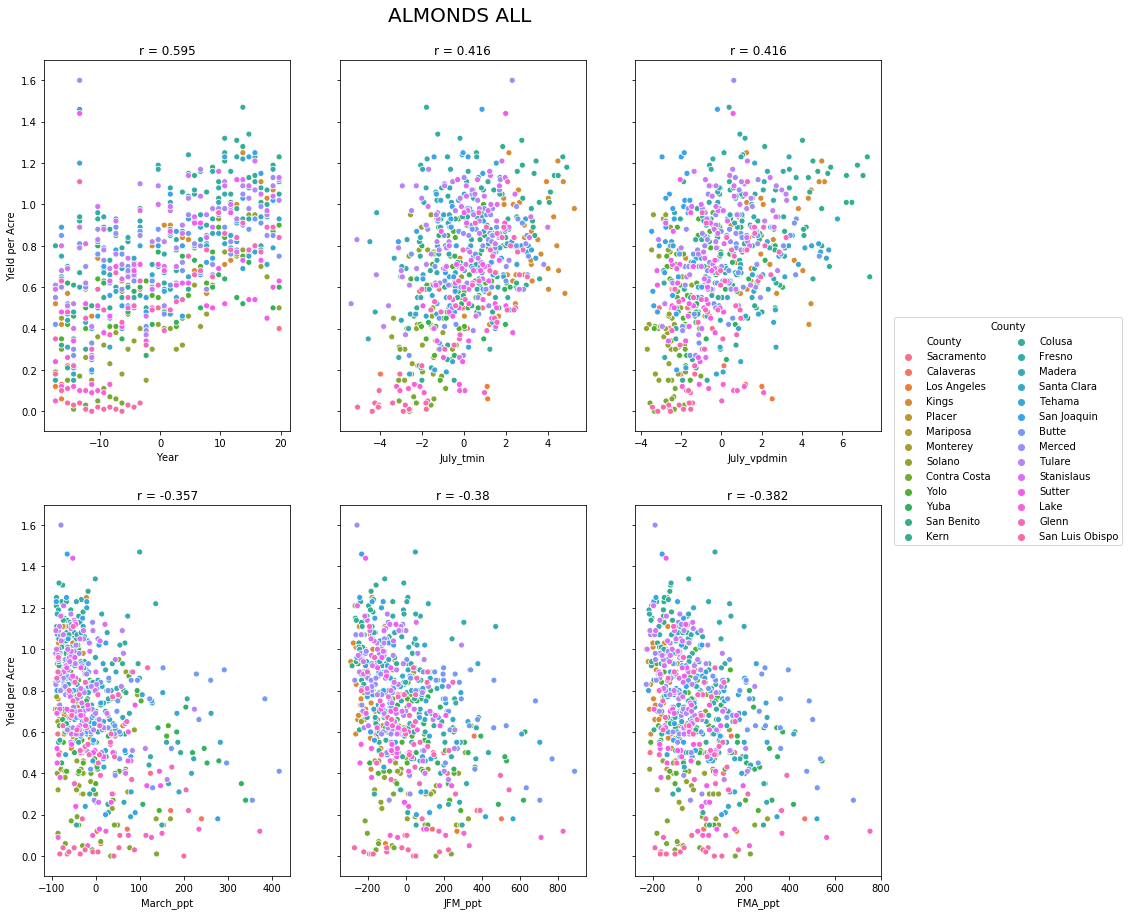

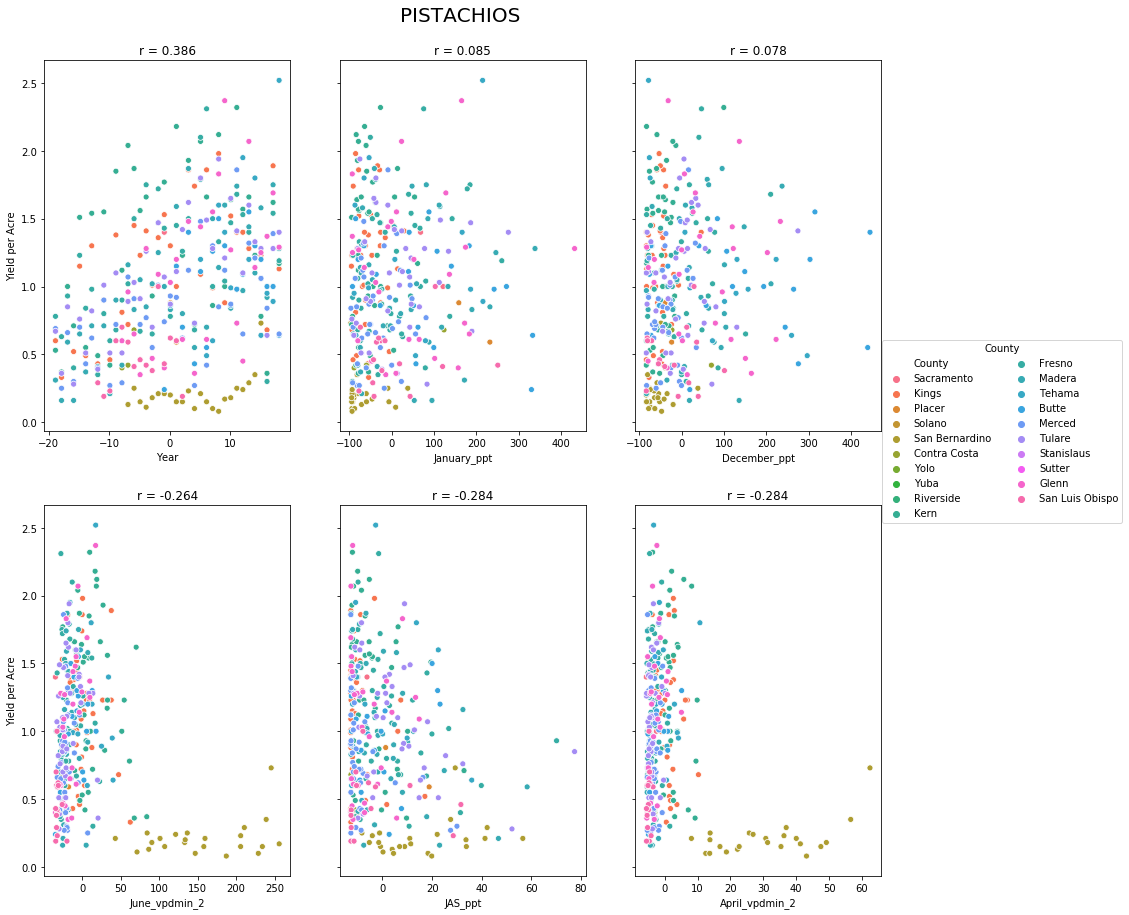

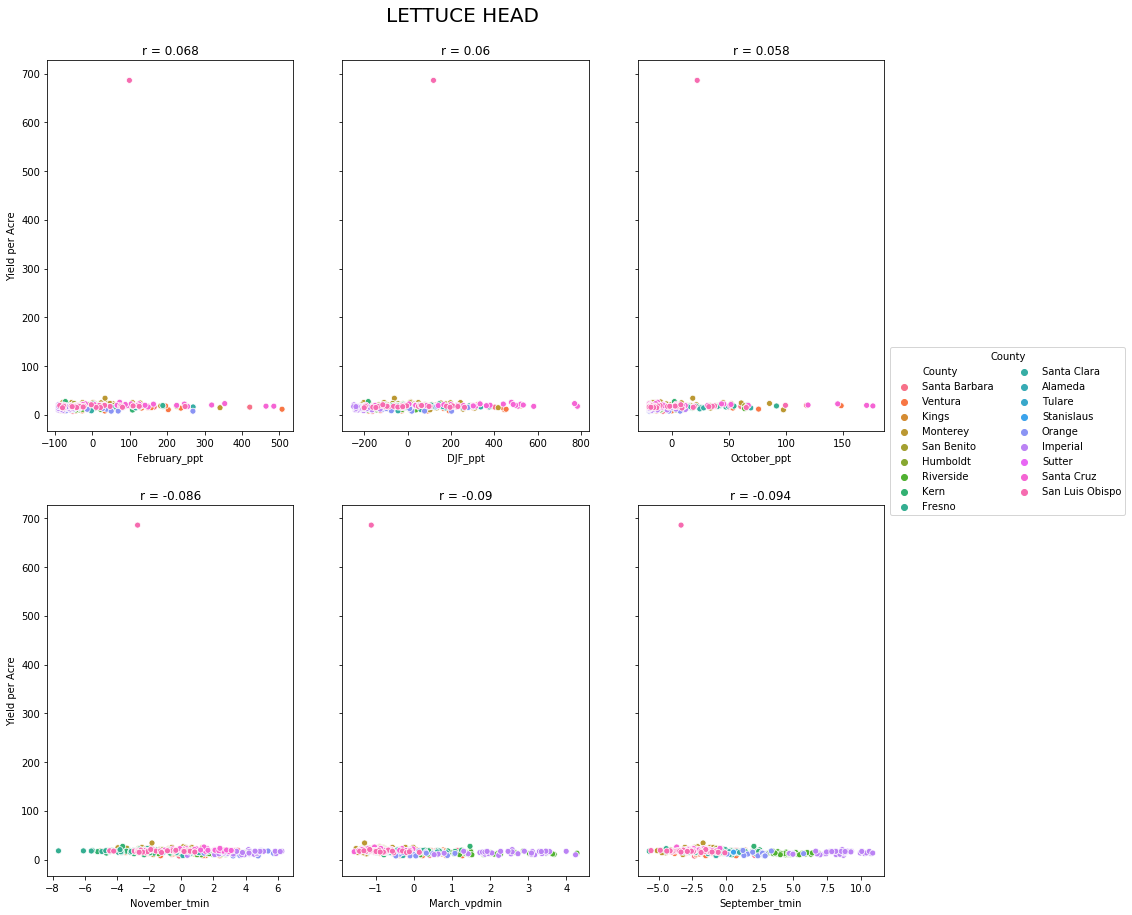

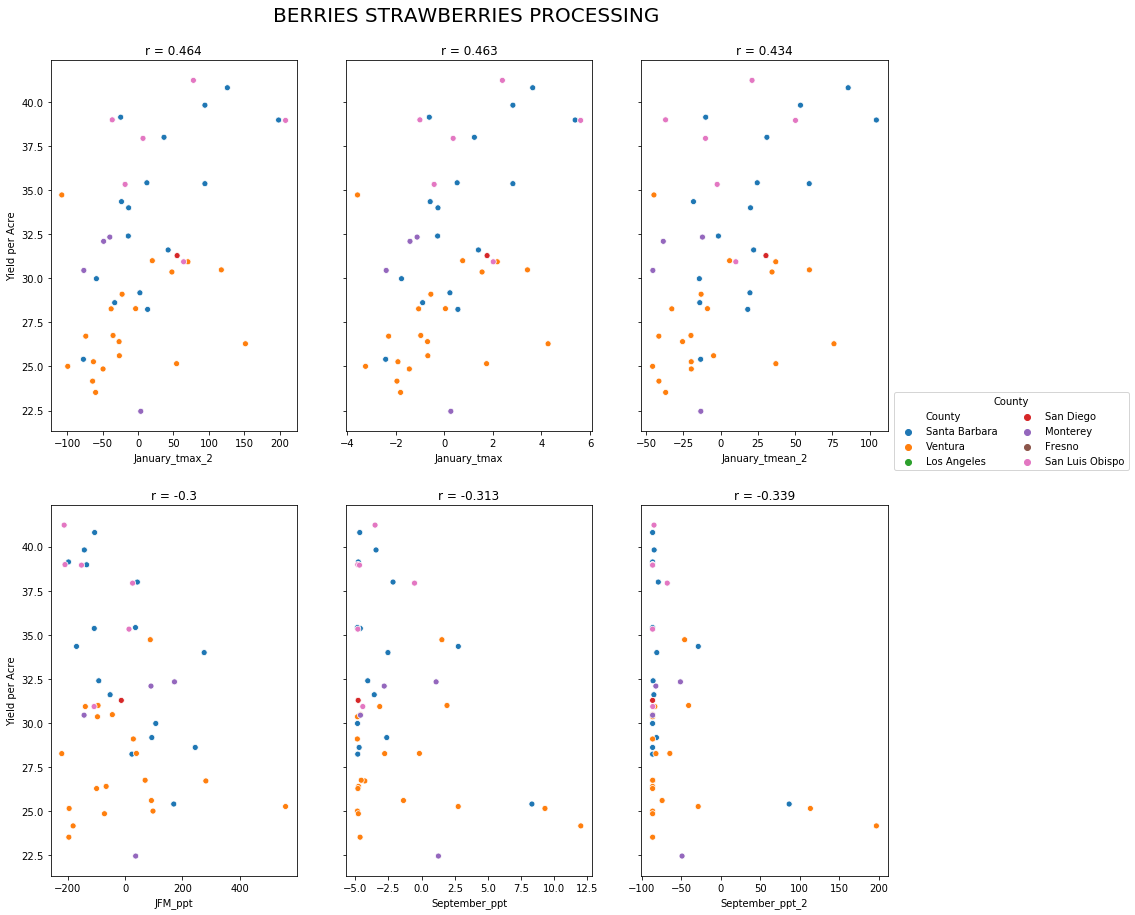

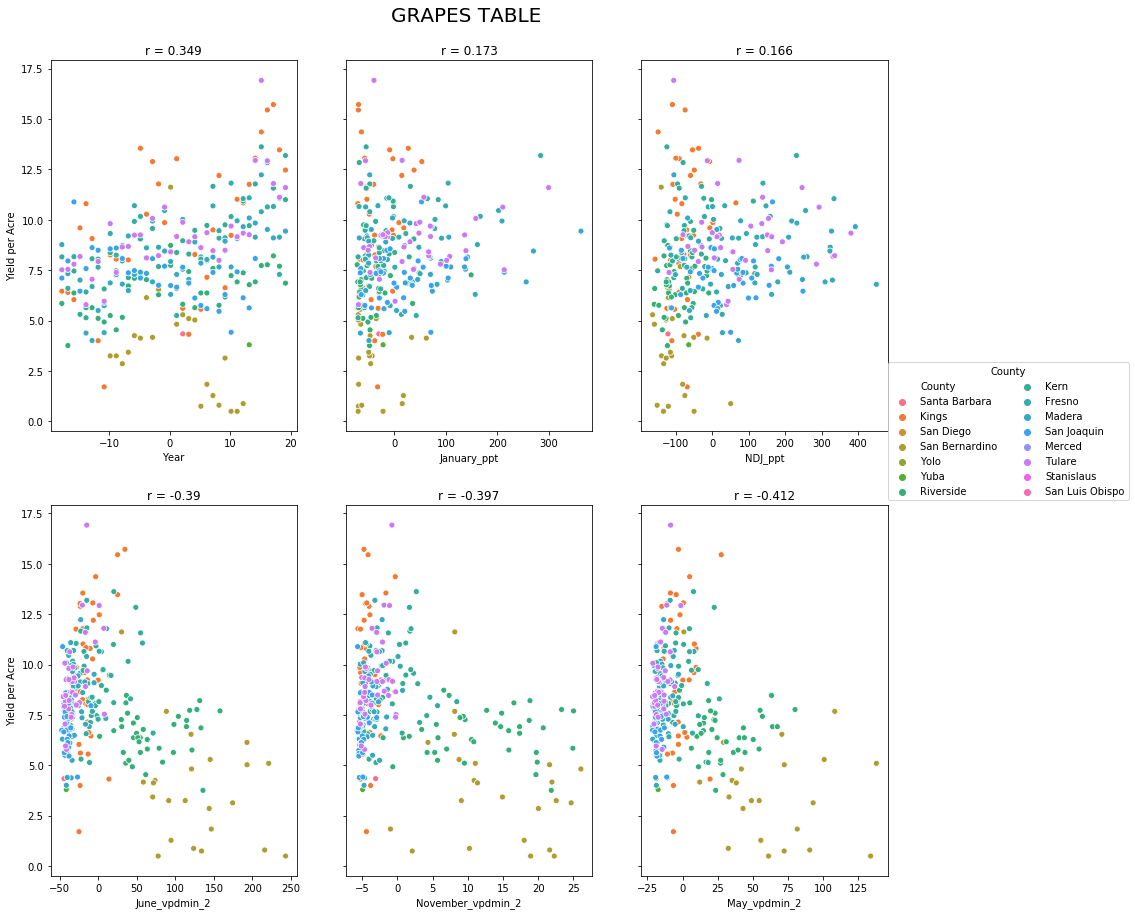

In [0]:
for crop in df_centered['Crop Name'].unique():
  
  #Filter to crop of interest
  df_crop = df_centered[df_centered['Crop Name'] == crop]
  
  #Drop unwanted columns
  df_crop = df_crop.drop(['County','Commodity Code', 'County Code', 'Harvested Acres',
                 'Production', 'Price per Unit', 'Total Value','Unit', 'Crop Name'], axis = 1)
  
  #Remove rows where nan values in target field
  df_crop = df_crop[pd.notnull(df_crop['Yield per Acre'])]
  
  #Find correlation between each predictor and target
  corrs = df_crop.drop('Yield per Acre', axis=1).apply(lambda x: x.corr(df_crop['Yield per Acre']))
  
  #Store correlations as a df, sort from greatest to least
  df_corr = corrs.sort_values(ascending = False).to_frame().reset_index().rename(columns = {'index':'Variable', 0:'Corr'})
  
  #Pick out top 3 and bottom 3
  df_vars = pd.concat([df_corr.head(3), df_corr.tail(3)])
  
  #Store variables as list
  vars = list(df_vars['Variable'].values)

  #Store correlations as list
  corr_values = list(df_vars['Corr'].values)
  
  #Plot scatter plots
  plot_matrix(vars, crop, corr_values)

**There are a few scatter plots where one outlier is obscuring the trend in the plot. We can plot those ones by hand.**

**WALNUTS ENGLISH**

(0, 3)

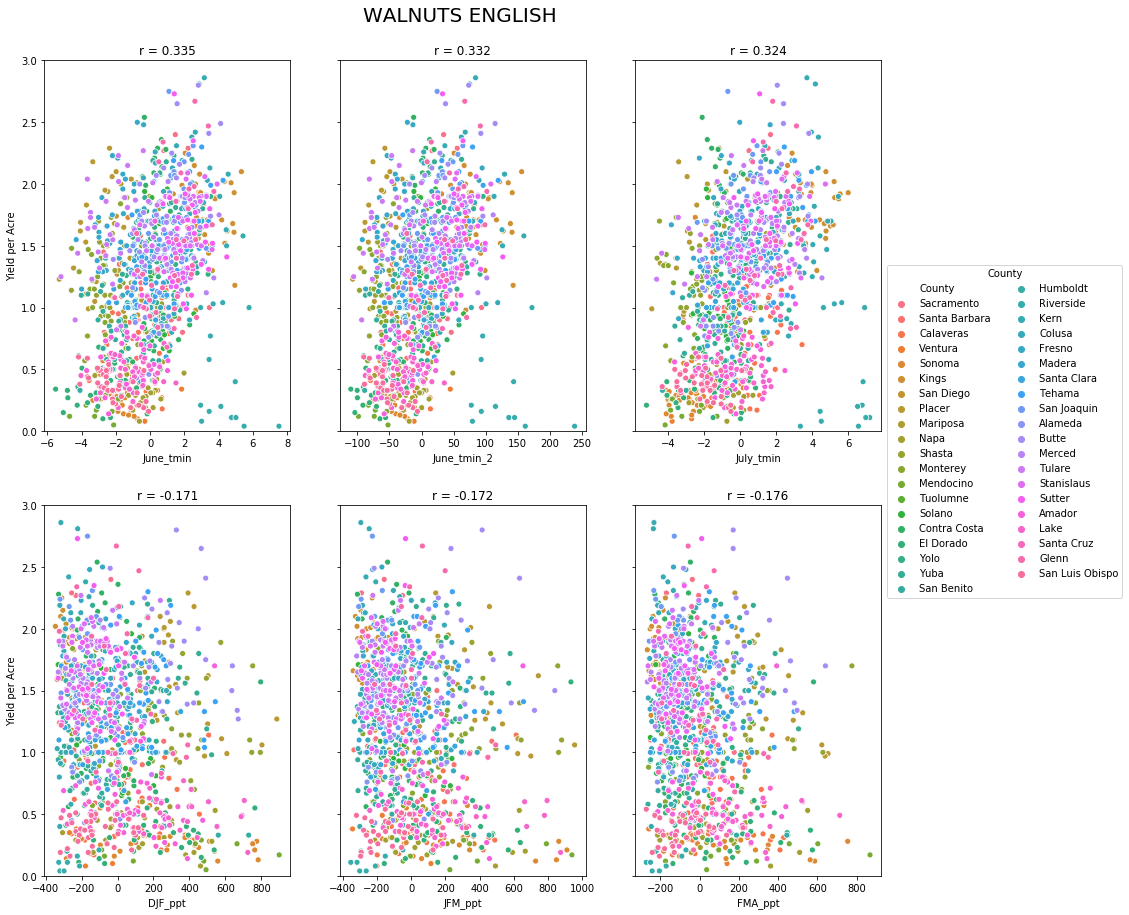

In [0]:
vars = ['June_tmin', 'June_tmin_2', 'July_tmin', 'DJF_ppt', 'JFM_ppt', 'FMA_ppt']
corr_values = [0.335, 0.332, 0.324, -0.171, -0.172, -0.176]

df_crop = df_centered[df_centered['Crop Name'] == 'WALNUTS ENGLISH']

fig, axes = plt.subplots(2, 3, figsize = (15,15), sharey = True)

sns.scatterplot(x = vars[0], y = 'Yield per Acre', hue = 'County', legend = False, data = df_crop, ax =axes[0,0])
axes[0,0].set_title('r = ' + str(round(corr_values[0],3)))

sns.scatterplot(x = vars[1], y = 'Yield per Acre', hue = 'County', legend = False, data = df_crop, ax =axes[0,1])
axes[0,1].set_title('r = ' + str(round(corr_values[1],3)))

sns.scatterplot(x = vars[2], y = 'Yield per Acre', hue = 'County', legend = False, data = df_crop, ax =axes[0,2])
axes[0,2].set_title('r = ' + str(round(corr_values[2],3)))

sns.scatterplot(x = vars[3], y = 'Yield per Acre', hue = 'County', legend = False, data = df_crop, ax =axes[1,0])
axes[1,0].set_title('r = ' + str(round(corr_values[3],3)))

sns.scatterplot(x = vars[4], y = 'Yield per Acre', hue = 'County', legend = False, data = df_crop, ax =axes[1,1])
axes[1,1].set_title('r = ' + str(round(corr_values[4],3)))

sns.scatterplot(x = vars[5], y = 'Yield per Acre', hue = 'County', data = df_crop, ax =axes[1,2])
axes[1,2].set_title('r = ' + str(round(corr_values[5],3)))

axes[1,2].legend(title = 'County', loc = 'center right', bbox_to_anchor = (2.0,1.2), ncol = 2)

plt.suptitle('WALNUTS ENGLISH', fontsize = 20, x = 0.51, y = 0.93)

plt.ylim(0,3)

# **Build Model**

https://www.pluralsight.com/guides/linear-lasso-ridge-regression-scikit-learn

https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/#four

http://www.science.smith.edu/~jcrouser/SDS293/labs/lab10-py.html

https://blog.datadive.net/selecting-good-features-part-ii-linear-models-and-regularization/

**At this point we need to drop columns that will not be part of the model. We also need to make sure that any NaNs are removed.**

In [0]:
#Let's do almonds only
df_almonds = df_centered_fixed[df_centered_fixed['Crop Name'] == 'ALMONDS ALL']

df_almond_model = df_almonds.drop(['County','Commodity Code', 'County Code', 'Harvested Acres',
                 'Price per Unit', 'Total Value','Unit', 'Crop Name', 'Production'], axis = 1)

#Make sure all NaN values are removed
df_almond_model = df_almond_model[pd.notnull(df_almond_model['Yield per Acre'])]

**We need to split our data in training and testing sets. We will use 30% of our data to test our model.**

In [0]:
from sklearn.model_selection import train_test_split
Y = df_almond_model['Yield per Acre']
X = df_almond_model.drop(['Yield per Acre'], axis = 1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, shuffle = False, stratify = None)

#Make sure the data is the right shape
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(461, 218) (461,)
(198, 218) (198,)


**Try playing around with alpha manually and see what happens.**

In [0]:
X_train.head(50)

Year  January_ppt  January_tmax  ...  Ventura      Yolo      Yuba
45   -4.301611   116.629649     -0.642806  ...      0.0 -0.055637 -0.055637
49   -3.301611   -56.283734      1.416856  ...      0.0 -0.055637 -0.055637
53   -2.301611   183.727321      0.938602  ...      0.0 -0.055637 -0.055637
57   -1.301611     0.821979      0.745919  ...      0.0 -0.055637 -0.055637
61   -0.301611   107.713435      0.378802  ...      0.0 -0.055637 -0.055637
66    0.698389    54.706325      0.511620  ...      0.0 -0.055637 -0.055637
117  19.698389   147.634029     -0.491041  ...      0.0 -0.055637 -0.055637
254 -16.301611   118.493922      0.994444  ...      0.0 -0.055637 -0.055637
257 -15.301611   145.818507     -3.481072  ...      0.0 -0.055637 -0.055637
260 -14.301611   126.062785     -1.384599  ...      0.0 -0.055637 -0.055637
285  -5.301611   -60.444608     -0.701649  ...      0.0 -0.055637 -0.055637
288  -4.301611   219.951015     -2.145560  ...      0.0 -0.055637 -0.055637
426 -17.301611    71.719859      3.243385  ...      0.0 -0.055637 -0.055637
427 -16.301611   -46.488965      4.992048  ...      0.0 -0.055637 -0.055637
494 -17.301611   -40.914944      1.287736  ...      0.0 -0.055637 -0.055637
500 -16.301611   -67.944421      2.487448  ...      0.0 -0.055637 -0.055637
506 -15.301611   -82.794135     -1.230629  ...      0.0 -0.055637 -0.055637
511 -14.301611   -19.328061     -1.950383  ...      0.0 -0.055637 -0.055637
517 -13.301611  -108.607420      0.349514  ...      0.0 -0.055637 -0.055637
523 -12.301611   -96.521238     -2.770099  ...      0.0 -0.055637 -0.055637
529 -11.301611   -75.800275      3.893226  ...      0.0 -0.055637 -0.055637
535 -10.301611   -70.165097     -0.542315  ...      0.0 -0.055637 -0.055637
542  -9.301611   -75.312638      0.802903  ...      0.0 -0.055637 -0.055637
548  -8.301611  -104.809641     -0.406425  ...      0.0 -0.055637 -0.055637
554  -7.301611   -68.629926      1.115550  ...      0.0 -0.055637 -0.055637
560  -6.301611   -98.570895      1.366618  ...      0.0 -0.055637 -0.055637
566  -5.301611   -76.040959     -3.363094  ...      0.0 -0.055637 -0.055637
572  -4.301611   -10.569203     -0.299998  ...      0.0 -0.055637 -0.055637
578  -3.301611   -86.501378      1.886670  ...      0.0 -0.055637 -0.055637
584  -2.301611    15.790393      1.864539  ...      0.0 -0.055637 -0.055637
590  -1.301611   -79.326014      1.209515  ...      0.0 -0.055637 -0.055637
596  -0.301611   -28.729413      1.142462  ...      0.0 -0.055637 -0.055637
602   0.698389   -63.501149      1.794587  ...      0.0 -0.055637 -0.055637
608   1.698389   -40.554608     -0.697975  ...      0.0 -0.055637 -0.055637
614   2.698389   -69.168130      2.850580  ...      0.0 -0.055637 -0.055637
620   3.698389   -60.250844      1.662318  ...      0.0 -0.055637 -0.055637
626   4.698389   -91.612838     -0.409956  ...      0.0 -0.055637 -0.055637
632   5.698389  -104.330848      1.582945  ...      0.0 -0.055637 -0.055637
638   6.698389   -85.456841     -0.641211  ...      0.0 -0.055637 -0.055637
644   7.698389   -42.211964     -0.751300  ...      0.0 -0.055637 -0.055637
650   8.698389   -23.142484      1.790771  ...      0.0 -0.055637 -0.055637
656   9.698389   -98.717084      1.169322  ...      0.0 -0.055637 -0.055637
662  10.698389   -39.523953      0.444976  ...      0.0 -0.055637 -0.055637
668  11.698389   -91.027663      1.712413  ...      0.0 -0.055637 -0.055637
674  12.698389   -39.636311      0.486425  ...      0.0 -0.055637 -0.055637
680  13.698389   -77.776353     -1.235023  ...      0.0 -0.055637 -0.055637
686  14.698389   -95.216693      3.688361  ...      0.0 -0.055637 -0.055637
692  15.698389  -101.647807      1.015458  ...      0.0 -0.055637 -0.055637
698  16.698389  -107.474328      6.787826  ...      0.0 -0.055637 -0.055637
704  17.698389  -107.218675      1.324635  ...      0.0 -0.055637 -0.055637

[50 rows x 218 columns]

In [0]:
from sklearn.linear_model import Lasso
model_lasso = Lasso(alpha = 4, max_iter =1e4)
model_lasso.fit(X_train, Y_train)
pred_train_lasso= model_lasso.predict(X_train)

from sklearn.metrics import r2_score
print(r2_score(Y_train, pred_train_lasso))

0.3783948702423465


In [0]:
#How many coefs are zero?
len(np.where(model_lasso.coef_ == 0)[0])

196

In [0]:
pred_test_lasso= model_lasso.predict(X_test)
print(r2_score(Y_test, pred_test_lasso))

0.2849304239517698


**Try finding alpha using CV**

In [0]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

lasso = Lasso(max_iter = 10000, normalize = False)

#No need to normalize! Already did that by subtracting mean!
lassocv = LassoCV(alphas = None, cv = 5, max_iter = 100000, normalize = False)
lassocv.fit(X_train, Y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, Y_train)

Lasso(alpha=16.918443661974017, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [0]:
#R2 for train set
pred_train_lasso= lasso.predict(X_train)
print('Train', r2_score(Y_train, pred_train_lasso))

#R2 for test set
print('Test', r2_score(Y_test, lasso.predict(X_test)))

#MSE for train set
print('MSE train', mean_squared_error(Y_train, lasso.predict(X_train)))

#Huge MSE from test set
print('MSE test', mean_squared_error(Y_test, lasso.predict(X_test)))

Train 0.3065656906882753
Test 0.22720061725871532
MSE train 0.05664088485129055
MSE test 0.08146477979229491


In [0]:
lassocv.mse_path_.shape

(100, 5)

In [0]:
lassocv.alphas_.shape

(100,)

In [0]:
lassocv.mse_path_

array([[0.09930745, 0.088825  , 0.09413184, 0.0900837 , 0.06540233],
       [0.09870188, 0.08802097, 0.0940868 , 0.08912437, 0.06529823],
       [0.09816688, 0.08733806, 0.09285737, 0.08829861, 0.06371418],
       [0.09769383, 0.08675938, 0.09173138, 0.08758843, 0.06247095],
       [0.09727518, 0.08627033, 0.09069916, 0.08697824, 0.06151508],
       [0.09690433, 0.08585827, 0.08975209, 0.08645451, 0.06080069],
       [0.09657551, 0.08551227, 0.08888237, 0.08600551, 0.06028844],
       [0.09628366, 0.0852229 , 0.08808305, 0.08562106, 0.05994466],
       [0.09602437, 0.084982  , 0.08734784, 0.08529236, 0.05974053],
       [0.09579376, 0.08478254, 0.08667108, 0.08501175, 0.05965148],
       [0.09558844, 0.08461843, 0.08604768, 0.08477261, 0.05965656],
       [0.09540543, 0.08448444, 0.08547304, 0.08456922, 0.05973794],
       [0.09524213, 0.08437605, 0.08494298, 0.08439661, 0.05988049],
       [0.09509625, 0.08428939, 0.08445374, 0.08425047, 0.06007141],
       [0.09496578, 0.08422111, 0.

# Week 6 Model Work

Resources
https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html

**We will start out only looking at almonds.**

**We will consider the dataset that has the fixed effects. Drop all non-essential columns such as county code, harvested acres, etc. Also critical to remove any NaN values.**

In [0]:
#Let's do almonds only
df_almonds = df_centered_fixed[df_centered_fixed['Crop Name'] == 'ALMONDS ALL']

#Drop non-essential columns
df_almond_model = df_almonds.drop(['County','Commodity Code', 'County Code', 'Harvested Acres',
                 'Price per Unit', 'Total Value','Unit', 'Crop Name', 'Production'], axis = 1)

#Make sure all NaN values are removed
df_almond_model = df_almond_model[pd.notnull(df_almond_model['Yield per Acre'])]

**Now we split the data into training and testing sets. We will NOT be shuffling the data.**

In [0]:
#Import package
from sklearn.model_selection import train_test_split

#Y is the target, X is the predictor
Y = df_almond_model['Yield per Acre']
X = df_almond_model.drop(['Yield per Acre'], axis = 1)

#30% test, 70% train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, shuffle = False, stratify = None)

#Make sure the data is the right shape
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(461, 218) (461,)
(198, 218) (198,)


**We can use LassoCV to start us off in the right direction.**

In [0]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

#10,000 iterations, no normalization
lasso = Lasso(max_iter = 10000, normalize = True)

#Not specifying alphas to see what LassoCV comes up with
lassocv = LassoCV(alphas = None, n_alphas = 200, cv = 5, max_iter = 100000, normalize = True)
lassocv.fit(X_train, Y_train)

#Use lassoCV params in lasso model
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, Y_train)

print('MSE on train set:', mean_squared_error(Y_train, lasso.predict(X_train)))
print('MSE on test set:', mean_squared_error(Y_test, lasso.predict(X_test)))

print('R2 on train set:', r2_score(Y_train, lasso.predict(X_train)))
print('R2 on test set:', r2_score(Y_test, lasso.predict(X_test)))

MSE on train set: 0.016068070861587673
MSE on test set: 0.06177647070012658
R2 on train set: 0.8032842945668949
R2 on test set: 0.41396983399802556


**Look at the parameters of the value.**

In [0]:
lasso.get_params

<bound method BaseEstimator.get_params of Lasso(alpha=6.033122535139211e-05, copy_X=True, fit_intercept=True,
      max_iter=10000, normalize=True, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)>

**What features were selected?**

In [0]:
almond_features = pd.DataFrame({'Features': X_train.columns.values, 'Coef': lasso.coef_})
almond_features_filtered = almond_features[almond_features['Coef'] != 0]
almond_features_filtered = almond_features_filtered.sort_values(by = 'Coef')

In [0]:
almond_features_filtered.tail(10)

Features      Coef
30        May_vpdmin  0.014755
181            Kings  0.017633
18      March_vpdmin  0.024226
42       July_vpdmin  0.031732
180             Kern  0.055920
72   December_vpdmin  0.063384
188           Merced  0.065132
171            Butte  0.068750
176           Fresno  0.114936
200      San Joaquin  0.116949

**It's great that LassoCV can find an alpha value for us, but it would be more informative to see how it is selecting this value.**

**The mse_path_ attribute shows the mean square error for the test set on each fold, varying alpha. We can plot this against the alphas_ attribute which is all the alphas the model tried.**

Text(0, 0.5, 'Mean MSE for Each Iteration')

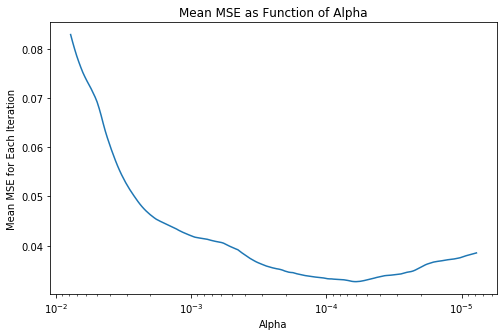

In [0]:
#Mean MSE for each iteration (5 folds per iteration)
mse = lassocv.mse_path_.mean(axis = 1)

#All the alphas
alphas = lassocv.alphas_

#Construct plot
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(alphas,mse)

#Reverse x axis and set a log scale
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])

#Format
plt.title('Mean MSE as Function of Alpha')
plt.xlabel('Alpha')
plt.ylabel('Mean MSE for Each Iteration')

**Averaging the MSE for all the folds was not good idea. Better to see how each of the five folds performed.**

Text(0, 0.5, 'Mean MSE for Each Iteration')

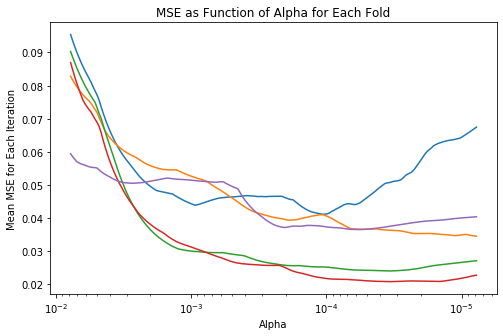

In [0]:
#Data
mse = lassocv.mse_path_
alphas = lassocv.alphas_

#Construct plot
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(alphas,mse)

#Reverse x axis and set a log scale
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])

#Format
plt.title('MSE as Function of Alpha for Each Fold')
plt.xlabel('Alpha')
plt.ylabel('Mean MSE for Each Iteration')

**The plot does not look like I expected it to look. Why does MSE drop off so suddenly when it gets close to zero? Doesn't this mean that multiple linear regression would yield simmilar results?**

**Can I reproduce this graph if I run the model myself? Specify my own alphas, fit model based on training data, find MSE.**

In [0]:
from sklearn import linear_model

#Number of alphas
n_alphas = 200

alphas =  np.logspace(-6, 6, n_alphas)

#MSE
MSE = []

#normalize TRUE
for a in alphas:
    lasso = linear_model.Lasso(alpha=a, fit_intercept=False, normalize = False)
    lasso.fit(X_train, Y_train)
    MSE.append(mean_squared_error(Y_train, lasso.predict(X_train)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.912431189187161, tolerance: 0.02647649000000001
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.913623759803638, tolerance: 0.02647649000000001
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.914993656471934, tolerance: 0.02647649000000001
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.91656736

**Plot MSE against alpha.**

Text(0, 0.5, 'MSE')

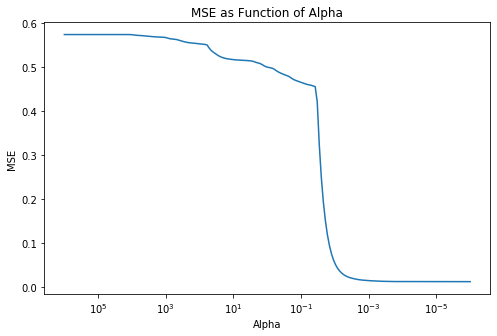

In [0]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(alphas,MSE)

#Reverse x axis
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])

#Format
plt.title('MSE as Function of Alpha')
plt.xlabel('Alpha')
plt.ylabel('MSE')

**Focus on even smaller alphas to make sure not missing anything.**

In [0]:
from sklearn import linear_model

#Number of alphas
n_alphas = 200

alphas =  np.logspace(-10, 1, n_alphas)

#MSE
MSE = []
for a in alphas:
    lasso = linear_model.Lasso(alpha=a, fit_intercept=False, normalize = False)
    lasso.fit(X_train, Y_train)
    MSE.append(mean_squared_error(Y_train, lasso.predict(X_train)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9044306378008597, tolerance: 0.02647649000000001
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9044307681489907, tolerance: 0.02647649000000001
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9044309161531308, tolerance: 0.02647649000000001
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.90443

**Plot results.**

Text(0, 0.5, 'MSE')

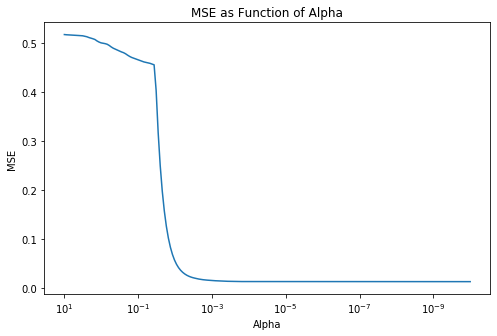

In [0]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(alphas,MSE)

#Reverse x axis
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])

#Format
plt.title('MSE as Function of Alpha')
plt.xlabel('Alpha')
plt.ylabel('MSE')

**Ok so that looks pretty bad. Do other crops do this?**

In [0]:
#Let's do almonds only
df_walnut = df_centered_fixed[df_centered_fixed['Crop Name'] == 'WALNUTS ENGLISH']

#Drop non-essential columns
df_walnut_model = df_walnut.drop(['County','Commodity Code', 'County Code', 'Harvested Acres',
                 'Price per Unit', 'Total Value','Unit', 'Crop Name', 'Production'], axis = 1)

#Make sure all NaN values are removed
df_walnut_model = df_walnut_model[pd.notnull(df_walnut_model['Yield per Acre'])]

#Import package
from sklearn.model_selection import train_test_split

#Y is the target, X is the predictor
Y = df_walnut_model['Yield per Acre']
X = df_walnut_model.drop(['Yield per Acre'], axis = 1)

#30% test, 70% train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, shuffle = False, stratify = None)

#Make sure the data is the right shape
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(812, 218) (812,)
(349, 218) (349,)


In [0]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

#10,000 iterations, no normalization
lasso = Lasso(max_iter = 10000, normalize = False)

#Not specifying alphas to see what LassoCV comes up with
lassocv = LassoCV(alphas = None, n_alphas = 200, cv = 5, max_iter = 100000, normalize = False)
lassocv.fit(X_train, Y_train)

#Use lassoCV params in lasso model
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, Y_train)

print('MSE on train set:', mean_squared_error(Y_train, lasso.predict(X_train)))
print('MSE on test set:', mean_squared_error(Y_test, lasso.predict(X_test)))

print('R2 on train set:', r2_score(Y_train, lasso.predict(X_train)))
print('R2 on test set:', r2_score(Y_test, lasso.predict(X_test)))

MSE on train set: 0.5840468194014842
MSE on test set: 0.33954892547799354
R2 on train set: 0.0971352899442709
R2 on test set: 0.08075919147718846


Text(0, 0.5, 'Mean MSE for Each Iteration')

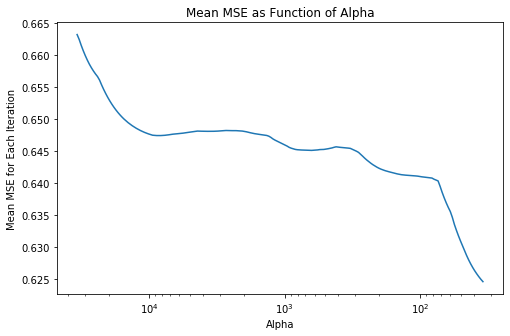

In [0]:
#Mean MSE for each iteration (5 folds per iteration)
mse = lassocv.mse_path_.mean(axis = 1)

alphas = lassocv.alphas_

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(alphas,mse)

#Reverse x axis
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])

#Format
plt.title('Mean MSE as Function of Alpha')
plt.xlabel('Alpha')
plt.ylabel('Mean MSE for Each Iteration')

In [0]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

#10,000 iterations, no normalization
lasso = Lasso(max_iter = 10000, normalize = False)

#Not specifying alphas to see what LassoCV comes up with
lassocv = LassoCV(alphas = np.linspace(1,0.00001).tolist(), cv = 5, normalize = False)
lassocv.fit(X_train, Y_train)

#Use lassoCV params in lasso model
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, Y_train)

print('MSE on train set:', mean_squared_error(Y_train, lasso.predict(X_train)))
print('MSE on test set:', mean_squared_error(Y_test, lasso.predict(X_test)))

print('R2 on train set:', r2_score(Y_train, lasso.predict(X_train)))
print('R2 on test set:', r2_score(Y_test, lasso.predict(X_test)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.00713477466263, tolerance: 0.04567883152542372
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7964246839167686, tolerance: 0.04567883152542372
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6363196717762207, tolerance: 0.04567883152542372
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to in

MSE on train set: 0.4353403389403068
MSE on test set: 0.21918988906361578
R2 on train set: 0.3270172598565064
R2 on test set: 0.4066001223263416


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133.5314031528552, tolerance: 0.052526808509852196
  positive)


Text(0, 0.5, 'Mean MSE for Each Iteration')

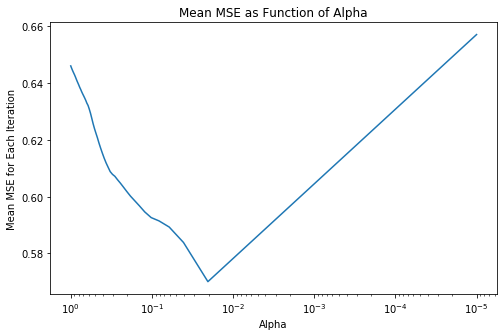

In [0]:
#Mean MSE for each iteration (5 folds per iteration)
mse = lassocv.mse_path_.mean(axis = 1)

alphas = lassocv.alphas_

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(alphas,mse)

#Reverse x axis
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])

#Format
plt.title('Mean MSE as Function of Alpha')
plt.xlabel('Alpha')
plt.ylabel('Mean MSE for Each Iteration')

# Data Normalization
Normalize data for each crop using sklearn's preprocessing tools.

https://datascience.stackexchange.com/questions/38395/standardscaler-before-and-after-splitting-data

In [0]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

**Prepare data for preprocessing. Filter down to just almonds. Get list of counties.**

In [0]:
#Filter down df that includes fixed effect of all crops to just almonds
df_almonds = df_weather_yield[df_weather_yield['Crop Name'] == 'ALMONDS ALL']

#Drop non-essential columns
df_almond_model = df_almonds.drop(['Commodity Code', 'County Code', 'Harvested Acres',
                 'Price per Unit', 'Total Value','Unit', 'Crop Name', 'Production'], axis = 1)

#Make sure all NaN values are removed
df_almond_model = df_almond_model[pd.notnull(df_almond_model['Yield per Acre'])]

**Split data in training and testing**

In [0]:
#Import package
from sklearn.model_selection import train_test_split

#Y is the target, X is the predictor
Y = df_almond_model['Yield per Acre']
X = df_almond_model.drop(['Yield per Acre'], axis = 1)

#30% test, 70% train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

#Make sure the data is the right shape
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)


(461, 170) (461,)
(198, 170) (198,)


In [0]:
# #Drop all non-predictor and non-target variables
# df_almond_model = df_almonds.drop(['County','Commodity Code', 'County Code', 'Harvested Acres',
#                  'Price per Unit', 'Total Value','Unit', 'Crop Name', 'Production'], axis = 1)

#Get a list of all counties (not just almonds)
counties = df_weather_yield['County'].unique()

**Create a list of all the desired features to scale. All non-fixed effects.**

In [0]:
almond_non_fixed = []

for var in X_train.columns.values:
  
  if var in counties:
    continue

  elif var == 'County':
    continue

  else:
    almond_non_fixed.append(var)

**Apply ColumnTransformer and StandardScaler.**

In [0]:
#almond_features = df_almond_model.drop(['Yield per Acre'], axis = 1)
#This transformer will scale all vairables that are contained in the almond_non_fixed variable
#All other variables will be passed through and not scaled.
ct = ColumnTransformer([('non_fixed',StandardScaler(), almond_non_fixed)], remainder = 'passthrough')


#Apply to ColumnTransformer to almond features
transformed_X_train = ct.fit_transform(X_train)
transformed_X_test = ct.transform(X_test)

In [0]:
#NOW NEED TO GET THE TRANSFORMED DATA BACK INTO A DATAFRAME

In [0]:
df_almond_transformed_features = pd.DataFrame(data = transformed_non_fixed_almonds, columns = almond_features.columns.values)
df_almond_transformed_features.head()

NameError: ignored

# New Workflow
Add engineered precip features, filter to crop, normalize BOTH train and test data together, add fixed effects, train/test split, run model with CV on years.

**Prepare data for preprocessing. Filter down to just almonds. Get list of counties.**

In [0]:
#Filter down df that includes fixed effect of all crops to just almonds
df_almonds = df_weather_yield[df_weather_yield['Crop Name'] == 'ALMONDS ALL']

#Drop non-essential columns
df_almond_model = df_almonds.drop(['Commodity Code', 'County Code', 'Harvested Acres',
                 'Price per Unit', 'Total Value','Unit', 'Crop Name', 'Production'], axis = 1)

#Make sure all NaN values are removed
df_almond_model = df_almond_model[pd.notnull(df_almond_model['Yield per Acre'])]

**Import packages and scale numeric data.**

In [0]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

#List of all counties, beyond just almonds
counties = df_weather_yield['County'].unique()

#Create scaler object
scaler = StandardScaler()

#Make a series of counties and yield per acre
almond_no_scale = df_almond_model[['County', 'Yield per Acre']].reset_index(drop = True)

#Fit and transform the data (now an array). Remove columns we don't want scaled
scaled_df = scaler.fit_transform(df_almond_model.drop(columns = ['County', 'Yield per Acre']))

#Convert array back to df
scaled_df_2 = pd.DataFrame(scaled_df, columns = df_almond_model.drop(columns = ['County', 'Yield per Acre']).columns)

#Add the counties and yield per acre back in
almond_scaled = scaled_df_2.join(almond_no_scale)

**Visualize effect of standardizing features.**

In [0]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 5))

ax1.set_title('Before Scaling')
sns.kdeplot(df_almond_model['January_tmax'], ax=ax1)
sns.kdeplot(df_almond_model['JFM_ppt_2'], ax=ax1)
sns.kdeplot(df_almond_model['December_vpdmax'], ax=ax1)

ax2.set_title('After Standard Scaler')
sns.kdeplot(almond_scaled['January_tmax'], ax=ax2)
sns.kdeplot(almond_scaled['JFM_ppt_2'], ax=ax2)
sns.kdeplot(almond_scaled['December_vpdmax'], ax=ax2)

plt.show()

**Now we need to add fixed effects for the counties.**

In [0]:
#Make a bunch of columns. One for each county.
dummy_counties = pd.get_dummies(almond_scaled['County'])

#Concat them to original df and rename to preserve original
almond_scaled_fixed = pd.concat([almond_scaled.drop(columns = 'County'), dummy_counties], axis = 1)
almond_scaled_fixed.head()

**Split into training and testing**

In [0]:
#Import package
from sklearn.model_selection import train_test_split

#Y is the target, X is the predictor
Y = almond_scaled_fixed['Yield per Acre']
X = almond_scaled_fixed.drop(['Yield per Acre'], axis = 1)

#30% test, 70% train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

#Make sure the data is the right shape
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

**Use LassoCV to predict yield. I should be cross validating across years, but I cannot yet figure out how to do that with LassoCV. Something to do with LeaveOneGroupOut.**

In [0]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

#10,000 iterations, no normalization bc we used StandardScaler
lasso = Lasso(max_iter = 10000, normalize = False)

#Not specifying alphas to see what LassoCV comes up with
lassocv = LassoCV(alphas = None, n_alphas = 200, cv = 5, max_iter = 100000, normalize = False)
lassocv.fit(X_train, Y_train)

#Use lassoCV params in lasso model
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, Y_train)

print('MSE on train set:', mean_squared_error(Y_train, lasso.predict(X_train)))
print('MSE on test set:', mean_squared_error(Y_test, lasso.predict(X_test)))

print('R2 on train set:', r2_score(Y_train, lasso.predict(X_train)))
print('R2 on test set:', r2_score(Y_test, lasso.predict(X_test)))

**Check out the parameters.**

In [0]:
print(lasso.get_params)
print(lasso.intercept_)


**MSE as Function of Alpha**

In [0]:
#Data
mse = lassocv.mse_path_
alphas = lassocv.alphas_

#Construct plot
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(alphas,mse)

#Reverse x axis and set a log scale
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])

#Format
plt.title('MSE as Function of Alpha for Each Fold')
plt.xlabel('Alpha')
plt.ylabel('Mean MSE for Each Iteration')

**Path of coefs**

In [0]:
np.logspace(-4, 0, n_alphas)

In [0]:
n_alphas = 200
alphas = np.logspace(-6, -1, n_alphas)

coefs = []
for a in alphas:
    lasso = linear_model.Lasso(alpha=a, normalize = False)
    lasso.fit(X_train, Y_train)
    coefs.append(lasso.coef_)

In [0]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(alphas, coefs)
ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('LASSO coefficients as a function of the regularization')
#plt.axis('tight')
plt.show()

**What features were selected?**

In [0]:
almond_features = pd.DataFrame({'Features': X_train.columns.values, 'Coef': lasso.coef_})
almond_features_filtered = almond_features[almond_features['Coef'] != 0]
almond_features_filtered = almond_features_filtered.sort_values(by = 'Coef', ascending = False)

In [0]:
almond_features_filtered.tail(10)

**How many were eliminated?**

In [0]:
almond_features[almond_features['Coef'] == 0].shape

**How many features total?**

In [0]:
almond_features.shape

Very confused by LeaveOneGroupOut but I think it is how I am supposed to cross validate across years.
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html
https://stackoverflow.com/questions/27097330/how-to-customize-sklearn-cross-validation-iterator-by-indices

In [0]:
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
y = np.array([1, 2, 1, 2])
groups = np.array([1, 1, 2, 2,])
logo = LeaveOneGroupOut()

In [0]:
for train_index, test_index in logo.split(X, y, groups):
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  print(X_train, X_test, y_train, y_test)

In [0]:
logo.split(X, y, groups)

In [0]:
X_test.head()

In [0]:
labels = np.arange(0, 10) % 2
logo = LeaveOneGroupOut()
logo.get_n_splits(groups = labels)

In [0]:
np.arange(0, 10) % 2

In [0]:
labels

In [0]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

#10,000 iterations, no normalization
lasso = Lasso(max_iter = 10000, normalize = False)

#Not specifying alphas to see what LassoCV comes up with
lassocv = LassoCV(alphas = None, n_alphas = 200, cv = 5, max_iter = 100000, normalize = False)
lassocv.fit(X_train, Y_train)

#Use lassoCV params in lasso model
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, Y_train)

print('MSE on train set:', mean_squared_error(Y_train, lasso.predict(X_train)))
print('MSE on test set:', mean_squared_error(Y_test, lasso.predict(X_test)))

print('R2 on train set:', r2_score(Y_train, lasso.predict(X_train)))
print('R2 on test set:', r2_score(Y_test, lasso.predict(X_test)))

For Presentation
GRAPES WINE

In [0]:
#Filter down df that includes fixed effect of all crops to just almonds
df_grapes = df_weather_yield[df_weather_yield['Crop Name'] == 'GRAPES WINE']

#Drop non-essential columns
df_grapes_model = df_grapes.drop(['Commodity Code', 'County Code', 'Harvested Acres',
                 'Price per Unit', 'Total Value','Unit', 'Crop Name', 'Production'], axis = 1)

#Make sure all NaN values are removed
df_grapes_model = df_grapes_model[pd.notnull(df_grapes_model['Yield per Acre'])]

In [0]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

#List of all counties, beyond just almonds
counties = df_weather_yield['County'].unique()

#Create scaler object
scaler = StandardScaler()

#Make a series of counties and yield per acre
grapes_no_scale = df_grapes_model[['County', 'Yield per Acre']].reset_index(drop = True)

#Fit and transform the data (now an array). Remove columns we don't want scaled
scaled_df = scaler.fit_transform(df_grapes_model.drop(columns = ['County', 'Yield per Acre']))

#Convert array back to df
scaled_df_2 = pd.DataFrame(scaled_df, columns = df_grapes_model.drop(columns = ['County', 'Yield per Acre']).columns)

#Add the counties and yield per acre back in
grapes_scaled = scaled_df_2.join(grapes_no_scale)

In [0]:
#Make a bunch of columns. One for each county.
dummy_counties = pd.get_dummies(grapes_scaled['County'])

#Concat them to original df and rename to preserve original
grapes_scaled_fixed = pd.concat([grapes_scaled.drop(columns = 'County'), dummy_counties], axis = 1)
grapes_scaled_fixed.head()

In [0]:
#Import package
from sklearn.model_selection import train_test_split

#Y is the target, X is the predictor
Y = grapes_scaled_fixed['Yield per Acre']
X = grapes_scaled_fixed.drop(['Yield per Acre'], axis = 1)

#30% test, 70% train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

#Make sure the data is the right shape
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

In [0]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

#10,000 iterations, no normalization bc we used StandardScaler
lasso = Lasso(max_iter = 10000, normalize = False)

#Not specifying alphas to see what LassoCV comes up with
lassocv = LassoCV(alphas = None, n_alphas = 200, cv = 5, max_iter = 100000, normalize = False)
lassocv.fit(X_train, Y_train)

#Use lassoCV params in lasso model
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, Y_train)

print('MSE on train set:', mean_squared_error(Y_train, lasso.predict(X_train)))
print('MSE on test set:', mean_squared_error(Y_test, lasso.predict(X_test)))

print('R2 on train set:', r2_score(Y_train, lasso.predict(X_train)))
print('R2 on test set:', r2_score(Y_test, lasso.predict(X_test)))

In [0]:
#Data
mse = lassocv.mse_path_
alphas = lassocv.alphas_

#Construct plot
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(alphas,mse)

#Reverse x axis and set a log scale
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])

#Format
plt.title('MSE as Function of Alpha for Each Fold')
plt.xlabel('Alpha')
plt.ylabel('Mean MSE for Each Iteration')

In [0]:
n_alphas = 200
alphas = np.logspace(-6, -1, n_alphas)

coefs = []
for a in alphas:
    lasso = linear_model.Lasso(alpha=a, normalize = False)
    lasso.fit(X_train, Y_train)
    coefs.append(lasso.coef_)

In [0]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(alphas, coefs)
ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('LASSO coefficients as a function of the regularization')
#plt.axis('tight')
plt.show()

In [0]:
grape_features = pd.DataFrame({'Features': X_train.columns.values, 'Coef': lasso.coef_})
grape_features_filtered = grape_features[grape_features['Coef'] != 0]
grape_features_filtered = grape_features_filtered.sort_values(by = 'Coef', ascending = False)

In [0]:
grape_features.shape

In [0]:
#Elminated
grape_features[grape_features['Coef'] == 0].shape

In [0]:
grape_features_filtered.tail()

NExt one for presentation

In [0]:
#Filter down df that includes fixed effect of all crops to just almonds
df_tomatoes = df_weather_yield[df_weather_yield['Crop Name'] == 'TOMATOES PROCESSING']

#Drop non-essential columns
df_tomatoes_model = df_tomatoes.drop(['Commodity Code', 'County Code', 'Harvested Acres',
                 'Price per Unit', 'Total Value','Unit', 'Crop Name', 'Production'], axis = 1)

#Make sure all NaN values are removed
df_tomatoes_model = df_tomatoes_model[pd.notnull(df_tomatoes_model['Yield per Acre'])]

In [0]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

#List of all counties, beyond just almonds
counties = df_weather_yield['County'].unique()

#Create scaler object
scaler = StandardScaler()

#Make a series of counties and yield per acre
tomatoes_no_scale = df_tomatoes_model[['County', 'Yield per Acre']].reset_index(drop = True)

#Fit and transform the data (now an array). Remove columns we don't want scaled
scaled_df = scaler.fit_transform(df_tomatoes_model.drop(columns = ['County', 'Yield per Acre']))

#Convert array back to df
scaled_df_2 = pd.DataFrame(scaled_df, columns = df_tomatoes_model.drop(columns = ['County', 'Yield per Acre']).columns)

#Add the counties and yield per acre back in
tomatoes_scaled = scaled_df_2.join(tomatoes_no_scale)

In [0]:
#Make a bunch of columns. One for each county.
dummy_counties = pd.get_dummies(tomatoes_scaled['County'])

#Concat them to original df and rename to preserve original
tomatoes_scaled_fixed = pd.concat([tomatoes_scaled.drop(columns = 'County'), dummy_counties], axis = 1)
tomatoes_scaled_fixed.head()

In [0]:
#Import package
from sklearn.model_selection import train_test_split

#Y is the target, X is the predictor
Y = tomatoes_scaled_fixed['Yield per Acre']
X = tomatoes_scaled_fixed.drop(['Yield per Acre'], axis = 1)

#30% test, 70% train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

#Make sure the data is the right shape
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

In [0]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

#10,000 iterations, no normalization bc we used StandardScaler
lasso = Lasso(max_iter = 10000, normalize = False)

#Not specifying alphas to see what LassoCV comes up with
lassocv = LassoCV(alphas = None, n_alphas = 200, cv = 5, max_iter = 100000, normalize = False)
lassocv.fit(X_train, Y_train)

#Use lassoCV params in lasso model
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, Y_train)

print('MSE on train set:', mean_squared_error(Y_train, lasso.predict(X_train)))
print('MSE on test set:', mean_squared_error(Y_test, lasso.predict(X_test)))

print('R2 on train set:', r2_score(Y_train, lasso.predict(X_train)))
print('R2 on test set:', r2_score(Y_test, lasso.predict(X_test)))

In [0]:
#Data
mse = lassocv.mse_path_
alphas = lassocv.alphas_

#Construct plot
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(alphas,mse)

#Reverse x axis and set a log scale
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])

#Format
plt.title('MSE as Function of Alpha for Each Fold')
plt.xlabel('Alpha')
plt.ylabel('Mean MSE for Each Iteration')

In [0]:
n_alphas = 200
alphas = np.logspace(-6, 0, n_alphas)

coefs = []
for a in alphas:
    lasso = linear_model.Lasso(alpha=a, normalize = False)
    lasso.fit(X_train, Y_train)
    coefs.append(lasso.coef_)

In [0]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(alphas, coefs)
ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('LASSO coefficients as a function of the regularization')
#plt.axis('tight')
plt.show()

In [0]:
tomatoes_features = pd.DataFrame({'Features': X_train.columns.values, 'Coef': lasso.coef_})
tomatoes_features_filtered = tomatoes_features[tomatoes_features['Coef'] != 0]
tomatoes_features_filtered = tomatoes_features_filtered.sort_values(by = 'Coef', ascending = False)

In [0]:
tomatoes_features.shape

In [0]:
tomatoes_features_filtered.shape

In [0]:
tomatoes_features_filtered

# Cross Validation By LeaveOneGroupOut

Split data into 4 folds. Divide into train and test. Specify all alphas. Run model for each alpha, save the MSE. Find average MSE over all folds for each alpha. Alpha with lowest mean MSE is the winner.

In [0]:
#Filter down df that includes fixed effect of all crops to just almonds
df_almonds = df_weather_yield[df_weather_yield['Crop Name'] == 'ALMONDS ALL']

#Drop non-essential columns
df_almond_model = df_almonds.drop(['Commodity Code', 'County Code', 'Harvested Acres',
                 'Price per Unit', 'Total Value','Unit', 'Crop Name', 'Production'], axis = 1)

#Make sure all NaN values are removed
df_almond_model = df_almond_model[pd.notnull(df_almond_model['Yield per Acre'])]

#Grab a list of the counties
almond_counties = df_almond_model['County'].unique()

In [0]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

#Create scaler object
scaler = StandardScaler()

#Make a series of counties and yield per acre
almond_no_scale = df_almond_model[['County', 'Yield per Acre']].reset_index(drop = True)

#Save a df of the years for later
almonds_years = df_almond_model[['Year']].reset_index(drop = True).rename(columns = {'Year':'Unscaled Year'})

#Fit and transform the data (now an array). Remove columns we don't want scaled
scaled_array = scaler.fit_transform(df_almond_model.drop(columns = ['County', 'Yield per Acre']))

#Convert array back to df
scaled_df = pd.DataFrame(scaled_array, columns = df_almond_model.drop(columns = ['County', 'Yield per Acre']).columns)

#Add the counties and yield per acre back in
almond_scaled = scaled_df.join(almond_no_scale)

#Add the years back in
almond_scaled = almond_scaled.join(almonds_years)

In [0]:
#Make a bunch of columns. One for each county.
dummy_counties = pd.get_dummies(almond_scaled['County'])

#Concat them to original df and rename to preserve original
almond_scaled_fixed = pd.concat([almond_scaled.drop(columns = 'County'), dummy_counties], axis = 1)
almond_scaled_fixed.head()

Year  January_ppt  January_tmax  ...  Tulare  Yolo  Yuba
0 -0.418543     1.191745     -0.310438  ...       0     0     0
1 -0.328376    -0.575816      0.694813  ...       0     0     0
2 -0.238210     1.877633      0.461393  ...       0     0     0
3 -0.148043     0.007932      0.367351  ...       0     0     0
4 -0.057876     1.100601      0.188173  ...       0     0     0

[5 rows x 193 columns]

In [0]:
#Import package
from sklearn.model_selection import train_test_split

#Y is the target, X is the predictor
Y = almond_scaled_fixed['Yield per Acre']
X = almond_scaled_fixed.drop(['Yield per Acre'], axis = 1)

#30% test, 70% train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

#Make sure the data is the right shape
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(461, 192) (461,)
(198, 192) (198,)


In [0]:
def grouper(x):
  if x <= 1988:
    return 1
  elif x > 1988 and x <=1997:
    return 2
  elif x > 1997 and x <= 2007:
    return 3
  elif x > 2007:
    return 4

X_train['CV Group'] = almond_scaled_fixed['Unscaled Year'].apply(grouper)
groups = X_train['CV Group'].values

#Now drop the unscaled years and CV groups on both training and testing because
#they are not features
X_train = X_train.drop(columns = ['Unscaled Year', 'CV Group'])
X_test = X_test.drop(columns = ['Unscaled Year'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [0]:
X = X_train.reset_index(drop = True)
y = Y_train.reset_index(drop = True)

logo = LeaveOneGroupOut()

gen_logo = logo.split(X, groups = groups)
lassoCV = linear_model.LassoCV(eps=0.0001, n_alphas=400, max_iter=200000, cv=gen_logo, normalize=False, random_state=9)  # pass it to the cv argument
lassoCV.fit(X, y)

LassoCV(alphas=None, copy_X=True,
        cv=<generator object BaseCrossValidator.split at 0x7f5f215b9468>,
        eps=0.0001, fit_intercept=True, max_iter=200000, n_alphas=400,
        n_jobs=None, normalize=False, positive=False, precompute='auto',
        random_state=9, selection='cyclic', tol=0.0001, verbose=False)

In [0]:
#Check that both the training and testing sets have the same number of features
print(Y_test.shape, X_test.shape)
print(Y_train.shape, X_train.shape)

(198,) (198, 191)
(461,) (461, 191)


In [0]:
#Use lassoCV params in lasso model
lasso.set_params(alpha=lassoCV.alpha_)
lasso.fit(X_train, Y_train)

print('MSE on train set:', mean_squared_error(Y_train, lasso.predict(X_train)))
print('MSE on test set:', mean_squared_error(Y_test, lasso.predict(X_test)))

print('R2 on train set:', r2_score(Y_train, lasso.predict(X_train)))
print('R2 on test set:', r2_score(Y_test, lasso.predict(X_test)))

MSE on train set: 0.01720949841515591
MSE on test set: 0.026235320978314745
R2 on train set: 0.8080119554667509
R2 on test set: 0.6999719922679735


In [0]:
features = pd.DataFrame({'Features': X_train.columns.values, 'Coef': lasso.coef_})
features_filtered = features[features['Coef'] != 0]
features_filtered = features_filtered.sort_values(by = 'Coef', ascending = False)

In [0]:
features_filtered.tail(10)

Features      Coef
70       December_tmean -0.034689
9         February_tmin -0.035235
49        September_ppt -0.041860
15           March_tmin -0.044120
56         October_tmax -0.046234
187              Tehama -0.049272
138  September_vpdmin_2 -0.066389
172        Contra Costa -0.159996
183     San Luis Obispo -0.208660
177                Lake -0.306709

In [0]:
#how to filter features to just counties or just weather
features_filtered[~features_filtered['Features'].isin(almond_counties)]

In [0]:
almond_counties

array(['Sacramento', 'Calaveras', 'Los Angeles', 'Kings', 'Solano',
       'Contra Costa', 'Yolo', 'Yuba', 'Kern', 'Colusa', 'Fresno',
       'Madera', 'Tehama', 'San Joaquin', 'Butte', 'Merced', 'Tulare',
       'Stanislaus', 'Sutter', 'Lake', 'Glenn', 'San Luis Obispo'],
      dtype=object)

# Lasso Model Function

**Grouper function used to sort observations into groups for LeaveOneGroupOut cross validation.**

In [0]:
def grouper(x):
  if x <= 1988:
    return 1
  elif x > 1988 and x <=1997:
    return 2
  elif x > 1997 and x <= 2007:
    return 3
  elif x > 2007:
    return 4

In [0]:
def crop_model(crop):
  ####DATA MUNGING####
  #Filter down complete dataset to crop of interest
  df_crop = df_weather_yield[df_weather_yield['Crop Name'] == crop]

  #Drop non-essential columns
  df_crop_model = df_crop.drop(['Commodity Code', 'County Code', 'Harvested Acres',
                 'Price per Unit', 'Total Value','Unit', 'Crop Name', 'Production'], axis = 1)

  #Make sure all NaN values are removed
  df_crop_model = df_crop_model[pd.notnull(df_crop_model['Yield per Acre'])]

  #Preserve a list of the counties
  crop_counties = df_crop_model['County'].unique()

  ###SCALE DATA###
  #Create scaler object
  scaler = StandardScaler()

  #Preserve a copy of counties and yield per acre. Don't want these scaled
  crop_no_scale = df_crop_model[['County', 'Yield per Acre']].reset_index(drop = True)

  #Preserve a copy of unscaled years and rename it
  crop_years = df_crop_model[['Year']].reset_index(drop = True).rename(columns = {'Year':'Unscaled Year'})

  #Fit and transform the data (now an array). Remove columns we don't want scaled.
  scaled_array = scaler.fit_transform(df_crop_model.drop(columns = ['County', 'Yield per Acre']))

  #Convert array back to df
  scaled_df = pd.DataFrame(scaled_array, columns = df_crop_model.drop(columns = ['County', 'Yield per Acre']).columns)

  #Add the counties and yield per acre back in
  crop_scaled = scaled_df.join(crop_no_scale)

  #Add the years back in
  crop_scaled = crop_scaled.join(crop_years)

  ###FIXED EFFECTS###
  #Make dummy columns for each county growing the crop
  dummy_counties = pd.get_dummies(crop_scaled['County'])

  #Concat them to original df and rename to preserve original
  crop_scaled_fixed = pd.concat([crop_scaled.drop(columns = 'County'), dummy_counties], axis = 1)

  ###TRAIN TEST SPLIT###
  #Y is the target, X is the predictor
  Y = crop_scaled_fixed['Yield per Acre']
  X = crop_scaled_fixed.drop(['Yield per Acre'], axis = 1)

  #30% test, 70% train
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

  #Make sure the data is the right shape
  print(X_train.shape, Y_train.shape)
  print(X_test.shape, Y_test.shape)

  ###CROSS VALIDATION###

  #Apply grouper function to unscaled years
  X_train['CV Group'] = crop_scaled_fixed['Unscaled Year'].apply(grouper)

  #Save groups for CV
  groups = X_train['CV Group'].values

  #Now drop the unscaled years and CV groups on both training and testing because
  #they are not features
  X_train = X_train.drop(columns = ['Unscaled Year', 'CV Group'])
  X_test = X_test.drop(columns = ['Unscaled Year'])

  #Reset index position of training data for readability
  X = X_train.reset_index(drop = True)
  y = Y_train.reset_index(drop = True)

  #Create LeaveOneGroupOut iterator for CV
  logo = LeaveOneGroupOut()
  gen_logo = logo.split(X, groups = groups)

  ###LASSO MODEL###
  #LassoCV to get parameters
  lassoCV = linear_model.LassoCV(eps=0.0001, n_alphas=400, max_iter=200000, cv=gen_logo, normalize=False, fit_intercept = True)  # pass it to the cv argument
  lassoCV.fit(X, y)

  #Run Lasso model with alpha value from CV
  lasso.set_params(alpha=lassoCV.alpha_)
  lasso.fit(X_train, Y_train)

  ###GOODNESS OF FIT###
  MSE_train = mean_squared_error(Y_train, lasso.predict(X_train))
  print('MSE on train set for ' + str(crop) + ':', mean_squared_error(Y_train, lasso.predict(X_train)))

  MSE_test = mean_squared_error(Y_test, lasso.predict(X_test))
  print('MSE on test set for ' + str(crop) + ':' , mean_squared_error(Y_test, lasso.predict(X_test)))

  R2_train = r2_score(Y_train, lasso.predict(X_train))
  print('R2 on train set for ' + str(crop) +':', r2_score(Y_train, lasso.predict(X_train)))

  R2_test = r2_score(Y_test, lasso.predict(X_test))
  print('R2 on test set for ' + str(crop) + ':', r2_score(Y_test, lasso.predict(X_test)))

  ###COEFFICIENT TABLES###
  #How many total features
  features = pd.DataFrame({'Features': X_train.columns.values, 'Coef': lasso.coef_})
  print('There were ' + str(features.shape[0]) + ' potential predictors for ' +str(crop))

  #How many non zero features?
  features_filtered = features[features['Coef'] != 0]
  print(str(features_filtered.shape[0]) + ' features have non-zero coefficients') 

  features_filtered = features_filtered.sort_values(by = 'Coef', ascending = False)

  #Return dictionary of results
  return {'Alpha':lassoCV.alpha_, 'Intercept':lassoCV.intercept_, 'MSE_train':MSE_train, 'MSE_test':MSE_test,
   'R2_train':R2_train, 'R2_test':R2_test, 'Filtered Features':features_filtered,
   'Crop Counties':crop_counties}

## Almonds

In [0]:
results = crop_model('ALMONDS ALL')

(461, 192) (461,)
(198, 192) (198,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


MSE on train set for ALMONDS ALL: 0.020410439296925233
MSE on test set for ALMONDS ALL: 0.022965791685999534
R2 on train set for ALMONDS ALL: 0.7839068539313906
R2 on test set for ALMONDS ALL: 0.6964771128740517
There were 191 potential predictors for ALMONDS ALL
57 features have non-zero coefficients


**Examine intercept**

In [0]:
results['Intercept']

0.671720287515437

In [0]:
df = results['Filtered Features']
counties = results['Crop Counties']
climate_coefs = df[~df['Features'].isin(counties)]
county_coefs = df[df['Features'].isin(counties)]

**Determine the mean yield. Compare to intercept.**

In [0]:
test = df_weather_yield.groupby(['County','Crop Name']).mean().reset_index()
test[(test['Crop Name'] == 'ALMONDS ALL') & (test['County'] == 'Stanislaus')]['Yield per Acre']

152    0.860526
Name: Yield per Acre, dtype: float64

**County Coefficients**

(array([-0.25, -0.2 , -0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,
         0.2 ]), <a list of 10 Text yticklabel objects>)

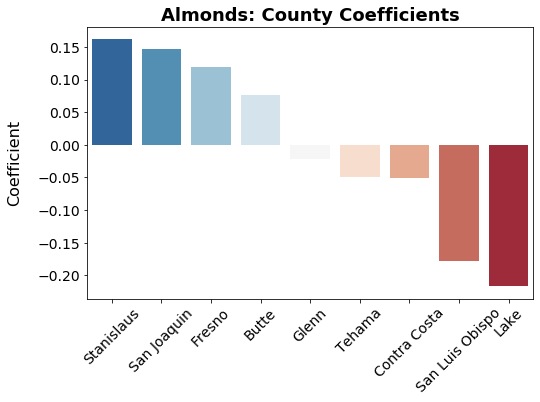

In [0]:
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.barplot(x = 'Features', y = 'Coef', data = county_coefs, palette = 'RdBu_r')
ax.set_title('Almonds: County Coefficients', fontsize = 18, fontweight = 'bold')
ax.set_ylabel('Coefficient', fontsize = 16, labelpad = 15)
ax.set_xlabel('')
plt.xticks(fontsize = 14, rotation = 45)
plt.yticks(fontsize = 14)

**Climate and Year Coefs**


No handles with labels found to put in legend.


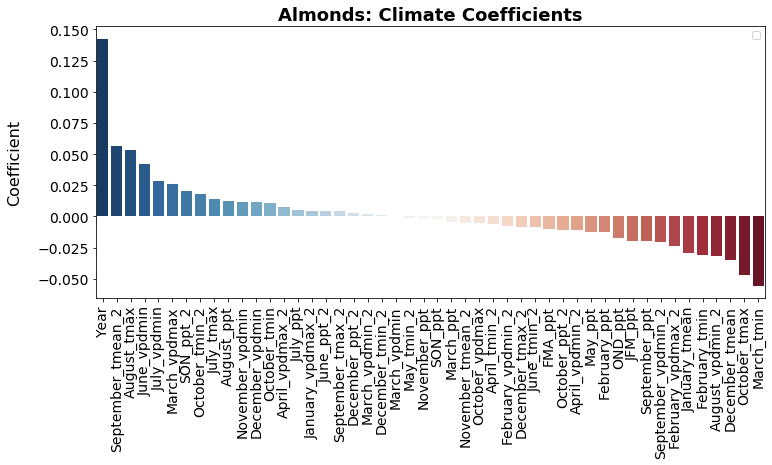

In [0]:
fig, ax = plt.subplots(figsize = (12,5))
ax = sns.barplot(x = 'Features', y = 'Coef', data = climate_coefs, palette = 'RdBu_r')
ax.set_title('Almonds: Climate Coefficients', fontsize = 18, fontweight = 'bold')
ax.set_ylabel('Coefficient', fontsize = 16, labelpad = 15)
ax.set_xlabel('')
plt.xticks(fontsize = 14, rotation = 90)
plt.yticks(fontsize = 14)
plt.legend()

**How much did climate influence yield per acre**

Should Y be the predicted values or the mean observed yield?

Y = B0 + fi + (weather)

Y - (B0 + fi) = weather

In [0]:
avg_yields = df_weather_yield.groupby(['County','Crop Name']).mean().reset_index()
avg_yields = avg_yields[pd.notnull(avg_yields['Yield per Acre'])]

avg_almonds = avg_yields[avg_yields['Crop Name'] == 'ALMONDS ALL'][['County', 'Yield per Acre']]

almond_intercept = results['Intercept']

avg_almonds['Yield per Acre - Intercept'] = avg_almonds['Yield per Acre'] - almond_intercept

avg_almonds

In [0]:
avg_almonds.merge(county_coefs, how = 'left', left_on = 'County', right_on = 'Features')

## Wine Grapes

In [0]:
results = crop_model('GRAPES WINE')

(810, 209) (810,)
(348, 209) (348,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


MSE on train set for GRAPES WINE: 2.0724293019284623
MSE on test set for GRAPES WINE: 1.978565156173212
R2 on train set for GRAPES WINE: 0.7946384867473206
R2 on test set for GRAPES WINE: 0.8057147557087068
There were 208 potential predictors for GRAPES WINE
86 features have non-zero coefficients


**Intercept**

In [0]:
results['Intercept']

4.65366306749128

**Coef dfs**

In [0]:
df = results['Filtered Features']
counties = results['Crop Counties']
climate_coefs = df[~df['Features'].isin(counties)]
county_coefs = df[df['Features'].isin(counties)]

In [0]:
county_coefs.shape

(25, 2)

**County Coefficients**

(array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 <a list of 11 Text yticklabel objects>)

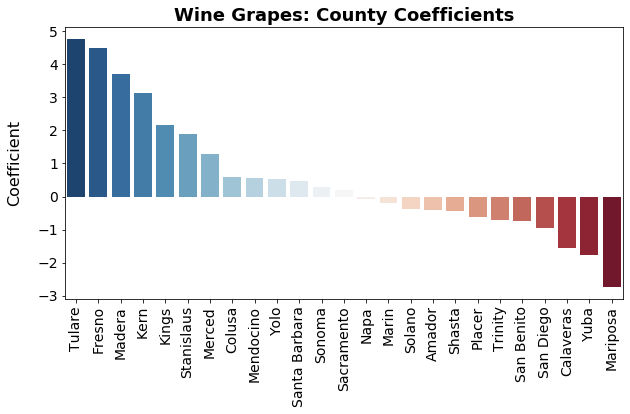

In [0]:
fig, ax = plt.subplots(figsize = (10,5))
ax = sns.barplot(x = 'Features', y = 'Coef', data = county_coefs, palette = 'RdBu_r')
ax.set_title('Wine Grapes: County Coefficients', fontsize = 18, fontweight = 'bold')
ax.set_ylabel('Coefficient', fontsize = 16, labelpad = 15)
ax.set_xlabel('')
plt.xticks(fontsize = 14, rotation = 90)
plt.yticks(fontsize = 14)

**Climate and Year Coef**

(array([-0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Text yticklabel objects>)

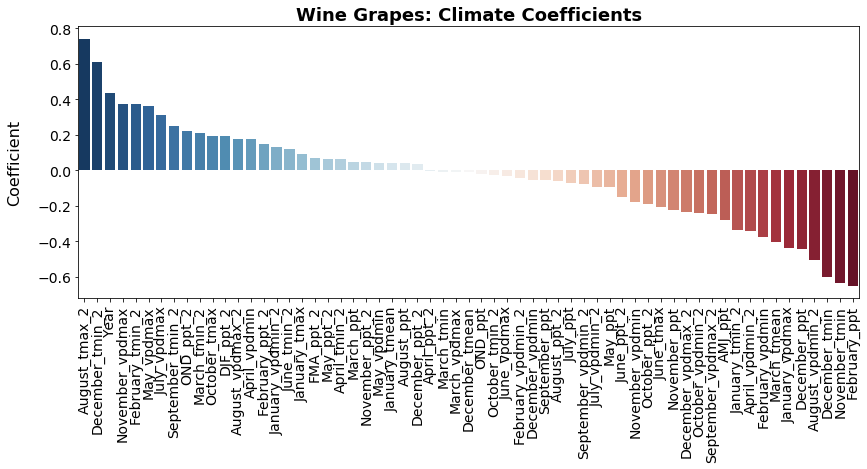

In [0]:
fig, ax = plt.subplots(figsize = (14,5))
ax = sns.barplot(x = 'Features', y = 'Coef', data = climate_coefs, palette = 'RdBu_r')
ax.set_title('Wine Grapes: Climate Coefficients', fontsize = 18, fontweight = 'bold')
ax.set_ylabel('Coefficient', fontsize = 16, labelpad = 15)
ax.set_xlabel('')
plt.xticks(fontsize = 14, rotation = 90)
plt.yticks(fontsize = 14)

In [0]:
df_weather_yield['Crop Name'].unique()

array(['GRAPES WINE', 'WALNUTS ENGLISH', 'TOMATOES PROCESSING',
       'ALMONDS ALL', 'PISTACHIOS', 'LETTUCE HEAD',
       'BERRIES STRAWBERRIES PROCESSING', 'GRAPES TABLE'], dtype=object)

In [0]:
df_weather_yield[df_weather_yield['Crop Name'] == 'GRAPES WINE']['Yield per Acre']


0       8.00
3       6.99
6       2.99
9       5.60
12      7.00
        ... 
4832    4.55
4836    3.82
4840    2.53
4844    3.87
4848    3.89
Name: Yield per Acre, Length: 1203, dtype: float64

## Walnuts

In [0]:
results = crop_model('WALNUTS ENGLISH')

(812, 206) (812,)
(349, 206) (349,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


MSE on train set for WALNUTS ENGLISH: 0.3984919781092502
MSE on test set for WALNUTS ENGLISH: 0.17635296857480287
R2 on train set for WALNUTS ENGLISH: 0.39938412976687576
R2 on test set for WALNUTS ENGLISH: 0.4653115409181442
There were 205 potential predictors for WALNUTS ENGLISH
49 features have non-zero coefficients


**Intercept**

In [0]:
results['Intercept']

1.2272594080876396

**Coefs dfs**

In [0]:
df = results['Filtered Features']
counties = results['Crop Counties']
climate_coefs = df[~df['Features'].isin(counties)]
county_coefs = df[df['Features'].isin(counties)]

In [0]:
county_coefs.shape

(11, 2)

**County Coefficients**

(array([-0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6]),
 <a list of 7 Text yticklabel objects>)

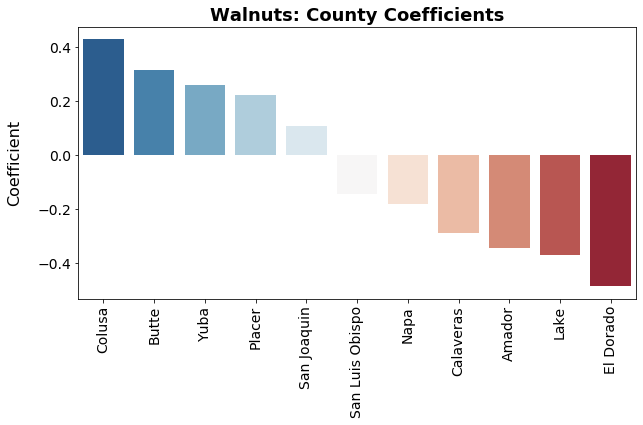

In [0]:
fig, ax = plt.subplots(figsize = (10,5))
ax = sns.barplot(x = 'Features', y = 'Coef', data = county_coefs, palette = 'RdBu_r')
ax.set_title('Walnuts: County Coefficients', fontsize = 18, fontweight = 'bold')
ax.set_ylabel('Coefficient', fontsize = 16, labelpad = 15)
ax.set_xlabel('')
plt.xticks(fontsize = 14, rotation = 90)
plt.yticks(fontsize = 14)

**Climate and Year**

(array([-0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,
         0.3 ]), <a list of 10 Text yticklabel objects>)

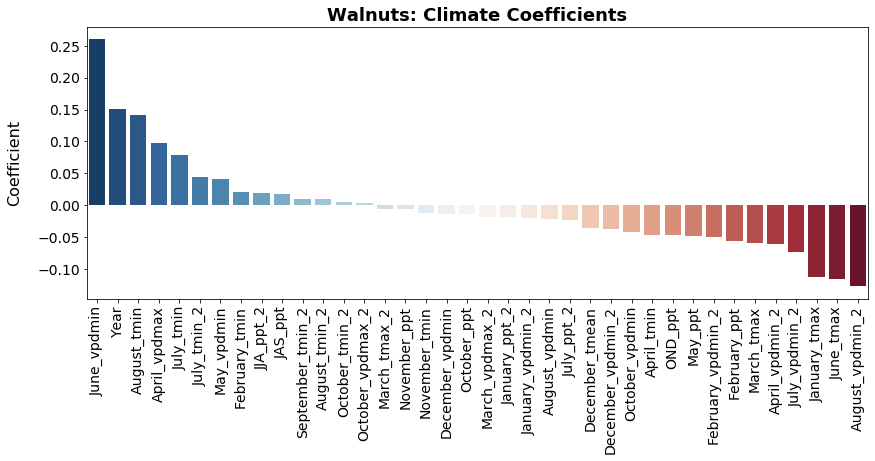

In [0]:
fig, ax = plt.subplots(figsize = (14,5))
ax = sns.barplot(x = 'Features', y = 'Coef', data = climate_coefs, palette = 'RdBu_r')
ax.set_title('Walnuts: Climate Coefficients', fontsize = 18, fontweight = 'bold')
ax.set_ylabel('Coefficient', fontsize = 16, labelpad = 15)
ax.set_xlabel('')
plt.xticks(fontsize = 14, rotation = 90)
plt.yticks(fontsize = 14)

# StandardScaler Change
Now just fitting based on training data.

In [0]:
#Filter down df that includes fixed effect of all crops to just almonds
df_grapes = df_weather_yield[df_weather_yield['Crop Name'] == 'GRAPES WINE']

#Drop non-essential columns
df_grapes_model = df_grapes.drop(['Commodity Code', 'County Code', 'Harvested Acres',
                 'Price per Unit', 'Total Value','Unit', 'Crop Name', 'Production'], axis = 1)

#Make sure all NaN values are removed
df_grapes_model = df_grapes_model[pd.notnull(df_grapes_model['Yield per Acre'])]

#List of climate predictors
climate_predictors = df_grapes_model.drop(['County', 'Yield per Acre'], axis = 1).columns.values

Now we add the fixed effects

In [0]:
#List of counties
grape_counties = df_grapes_model['County'].unique()

#Make dummies
dummy_counties = pd.get_dummies(df_grapes_model['County'])

#Concat
df_grapes_model_fixed = pd.concat([df_grapes_model.drop(columns = 'County'), dummy_counties], axis = 1)


Now we split into training and testing.

In [0]:
#Import package
from sklearn.model_selection import train_test_split

#Y is the target, X is the predictor
Y = df_grapes_model_fixed['Yield per Acre']
X = df_grapes_model_fixed.drop(['Yield per Acre'], axis = 1)

#30% test, 70% train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

#Make sure the data is the right shape
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

Now we standardize.

In [0]:
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer([('somename', StandardScaler(), climate_predictors)], remainder = 'passthrough')

#Scale data based on training set
X_train_scaled_array = ct.fit_transform(X_train)
X_test_scaled_array = ct.transform(X_test)

#Convert array to df
X_train_scaled = pd.DataFrame(X_train_scaled_array, columns = X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns = X_test.columns)

In [0]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

#10,000 iterations, no normalization bc we used StandardScaler
lasso = Lasso(max_iter = 10000, normalize = False)

#Not specifying alphas to see what LassoCV comes up with
lassocv = LassoCV(alphas = None, n_alphas = 200, cv = 5, max_iter = 100000, normalize = False)
lassocv.fit(X_train_scaled, Y_train)

#Use lassoCV params in lasso model
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train_scaled, Y_train)

print('MSE on train set:', mean_squared_error(Y_train, lasso.predict(X_train_scaled)))
print('MSE on test set:', mean_squared_error(Y_test, lasso.predict(X_test_scaled)))

print('R2 on train set:', r2_score(Y_train, lasso.predict(X_train_scaled)))
print('R2 on test set:', r2_score(Y_test, lasso.predict(X_test_scaled)))

In [0]:
grapes_features = pd.DataFrame({'Features': X_train_scaled.columns.values, 'Coef': lasso.coef_})
grapes_features_filtered = grapes_features[grapes_features['Coef'] != 0]
grapes_features_filtered = grapes_features_filtered.sort_values(by = 'Coef', ascending = False)

In [0]:
grapes_features_filtered.head(50)

In [0]:
#Make df of counties for both training and testing
X_train_counties = X_train[['County']]
X_test_counties = X_test[['County']]

#Create scaler object
scaler = StandardScaler()

#Fit StandardScaler on training only. Remove columns we don't want scaled
X_train_scaled_array = scaler.fit_transform(X_train.drop(columns = ['County']))

#Apply StandardScaler to testing data.
X_test_scaled_array = scaler.transform(X_test.drop(columns = ['County']))

#Convert arrays back to dfs
X_train_scaled = pd.DataFrame(X_train_scaled_array, columns = X_train.drop(columns = ['County']).columns)
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns = X_test.drop(columns = ['County']).columns)

#Add the counties back in
X_train_scaled = X_train_scaled.join(X_train_counties)
X_test_scaled = X_test_scaled.join(X_test_counties)

Add in fixed effects

In [0]:
#Make a bunch of columns. One for each county.
train_dummy_counties = pd.get_dummies(X['County'])
test_dummy_counties = pd.get_dummies(X['County'])

#Concat to scaled data
X_train_scaled = pd.concat([X_train_scaled.drop(columns = 'County'), train_dummy_counties], axis = 1)
X_test_scaled = pd.concat([X_test_scaled.drop(columns = 'County'), test_dummy_counties], axis = 1)

Check shapes

In [0]:
print(X_test_scaled.shape, Y_test.shape)
print(X_train_scaled.shape, Y_train.shape)

Run model

In [0]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

#10,000 iterations, no normalization bc we used StandardScaler
lasso = Lasso(max_iter = 100, normalize = False)

#Not specifying alphas to see what LassoCV comes up with
lassocv = LassoCV(alphas = None, n_alphas = 200, cv = 5, max_iter = 100000, normalize = False)
lassocv.fit(X_train_scaled, Y_train)

#Use lassoCV params in lasso model
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train_scaled, Y_train)

#print('MSE on train set:', mean_squared_error(Y_train, lasso.predict(X_train_scaled)))
#print('MSE on test set:', mean_squared_error(Y_test, lasso.predict(X_test_scaled)))

print('R2 on train set:', r2_score(Y_train, lasso.predict(X_train_scaled)))
print('R2 on test set:', r2_score(Y_test, lasso.predict(X_test_scaled)))

This does not work because some counties are in the test set but not in the training set. Different number of predictors.